<a href="https://colab.research.google.com/github/MSiba/ColabRepo/blob/main/regressor_semcor_index_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Checks

In [196]:
#!pip install numba

In [197]:
#!pip install bcolz

In [198]:
# Imports 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer


from collections import defaultdict, Counter

import math
from typing import Tuple
import numpy as np
import pandas as pd
import pickle
#import bcolz

import os
import time
import random
import functools
from datetime import datetime


import nltk
nltk.download("all")
# nltk.download("stopwords")
# nltk.download("punkt")
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from string import punctuation
from nltk import pos_tag, WordNetLemmatizer
from pprint import pprint
import string

import bz2
import pickle
import _pickle as cPickle

import numba
from numba import jit
from numba import njit


import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [199]:
print(torch.__version__)

1.11.0+cu113


In [200]:
# set seed to ensure the same initialization for every run

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [201]:
# To prevent Colab from disconnection
# while True:pass

### Check which GPU Google Colab is offering me at the moment

[Code Source](https://github.com/jeffheaton/present/blob/master/youtube/benchmark_colab.ipynb)

In [202]:
# Some checks

!ipython kernelspec list
import sys
print(sys.version)
print(sys.executable)

[TerminalIPythonApp] WARNING | Subcommand `ipython kernelspec` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter kernelspec` in the future
Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python3    /usr/local/share/jupyter/kernels/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
/usr/bin/python3


In [203]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  1 00:40:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   4681MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [204]:
# check how much RAM is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [205]:
# list cpu architecture information 
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

# Utils Functions (Loading Data, Vocab, Numericalization, Input Preprocessing, Tag Decoding)

In [206]:
def to_tensor(string_list):
    """
    Transforms a list of strings into a list of floats. 
    After writing the list to the .csv file, the list is transformed to list of strings.
    :param string_list: list of strings
    :return: torch tensor of float32
    """
    l_str = [] 
    for ele in string_list:
        if ele[0] == "[":
            l_str.append(ele[1:])
        else:
            if ele[-1] == "]":
                l_str.append(ele[:-1])
            else:
                l_str.append(ele)

    str_vec = " ".join(l_str)
    torch_labels = torch.tensor(list(map(float, str_vec.split(' '))), dtype=torch.float32)
    return torch_labels

In [207]:
def parse_data(file):
    """
    reads the stem word and the spatial tag of each token in the .csv file
    :param file: the csv file for training
    :return: List of training data of the form [[tokenized_sentence-1, spatial_tensors],
                                                [tokenized_sentence-1, spatial_tensors], ...]
    """
    with open(file, encoding='utf-8') as f:
        examples = []
        words = []
        lemmas = []
        synset_offset = []
        idx = []
        labels = []
        for line in f:
            # print("initial line ", line)
            line = line.strip()
            # print("STRIPPING line ", line)
            if not line:
                examples.append([lemmas, synset_offset, labels, idx])
                words = []
                lemmas = []
                synset_offset = []
                idx = []
                labels = []
            else:
                columns = line.split()
                # print("cols", columns)
                words.append(columns[0])
                lemmas.append(columns[1])
                synset_offset.append(columns[4])
                idx.append(int(columns[5]))
                lab = to_tensor(columns[-6:])
                labels.append(lab)

               

        return examples

In [208]:
def parse_semcor_file(file_path):

  data = torch.load(file_path)
 
  extracted_data = []
  for i, sent in enumerate(data):
      tmp_lemma = []
      tmp_tag = []
      tmp_synset = []
      tmp_idx = []
      for j, word in enumerate(sent): 
        tmp_lemma.append(word[0])
        tmp_tag.append(torch.from_numpy(word[4]))
        tmp_synset.append(word[2])
        tmp_idx.append(torch.from_numpy(word[3]))
      tmp_sent = [tmp_lemma, tmp_tag, tmp_synset, tmp_idx]
      extracted_data.append(tmp_sent)
  return extracted_data

In [209]:
def clean_untagged(data):
    """
    cleans the parsed data from a csv to remove entries that do not contain tagged senses.
    :param data: The parsed data
    return: original, and clean data
    """
    original_data = data
    for entry in data:
        
        idx = [i for i, syn in enumerate(entry[1]) if syn == 'no-synset']

        # remove those from the data
        for s in reversed(idx):
            del entry[0][s]
            del entry[1][s]
            del entry[2][s]

    return original_data, data

In [210]:
def data_id(data):
    """
    assigns for each sentence in the data an id to ease the splittings for training/validation.
    :param data: 
    :return data with ids
    """

    # data_collector = {"0": [[], []], "1": [[],[]], ...}
    data_collector = {}
    for i, instance in enumerate(data):
        data_collector[str(i)] = instance

    return data_collector

In [211]:
def load_vocab(data, embed_size=300):
    """
    loads the vocabulary from the data (words of sentences) and assigns for each word a glove embedding.
    :param data: words for training/validation/testing
    :return embed_size: vector embedding size 
    """

    data = list(data)
    
    # insert all dataset vocabulary
    dataset_vocab = []
    
    print(data[0])
    if isinstance(data[0], str):
        dataset_vocab = data
    else:
        for instance in data:            
            dataset_vocab += instance[0]
    
    # remove duplicates
    target_vocab = set(dataset_vocab)
    
    # generate weights matrix using glove
    matrix_len = len(target_vocab)
    
    weights_matrix = np.zeros((matrix_len, embed_size))
    
    words_found = 0

    for i, word in enumerate(target_vocab):
        try:
            weights_matrix[i] = glove[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_size, ))
    
    return target_vocab, weights_matrix

In [212]:
def numericalize(tokens_list, vocab):
    """
    gives a number to each word in the training/testing dataset, so that the sentences can be handled by torch using numbers.
    :param tokens_list: a sentence as list of tokens
    :param vocab: the vocabulary of all sentences in the training data.
    """
    
    str2num = {word: index for index, word in enumerate(vocab)}
    num_list = []
    for token in tokens_list:
        num_list.append(str2num[token])
        
    return torch.tensor(num_list, dtype=torch.long)


In [213]:
# Preprocess Input sentence

# set of english stop words U set of punctuation
EN_STOPWORDS_PUNCT = set(stopwords.words('english')).union(set(string.punctuation))
WN_LEMMATIZER = WordNetLemmatizer()


def tags4wn(tag):
    """Penn Treebank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    Converts PennTreeBank tags to WN tags, e.g. n, a, v"""
    tag_conversion = {"NN": "n", # noun
                      "JJ": "a", # adjective
                      "VB": "v", # verb
                      "RB": "r"} # adverb
    try:
        # return the WN tags
        return tag_conversion[tag[:2]]
    except:
        # if no tag is found, treat the word as a noun
        return "n"

def preprocess(sentence):
    """Preprocesses a raw input sentence and return a list of each word with its POS tag."""
    # Tokenization
    tokenized_sentence = nltk.word_tokenize(sentence)
    # lowercase all words
    lower = [word.lower() for word in tokenized_sentence]
    # print(lower)
    # delete stop words and punctuation
    clean_sentence = [word for word in lower if word not in EN_STOPWORDS_PUNCT]
    # print(clean_sentence)
    # use wordNet Lemmatizer to do POS and then lemmatize
    pos_tagging = pos_tag(clean_sentence)
    # print(pos_tagging)
    # Lemmatize
    lemmatized_sentence = [(WN_LEMMATIZER.lemmatize(word, pos=tags4wn(tag)), tags4wn(tag)) for word, tag in pos_tagging]
    # print(lemmatized_sentence)

    return lemmatized_sentence


In [268]:
def decode_tag(tokens, sentag_idx, sentag_dist, file, true_synsets=None):
    """
    decodes and prints the output of the vicinity matrix in a readable way.
    :param tokens: the words in the sentence to be tagged
    :param sentag_idx: the indices of the senses in the vicinity matrix
    :param sentag_dist: the distances to the senses in the vicinity matrix
    :param file: file to which print() is redirected
    :param true_synsets: the gold annotation of the word
    :return a print of the vicinity matrix 
    """

    # Vicinity Matrix decoding
    print("Please refer to the following descriptions to encode the relation between the predicted sphere and its vicinity.", file=file)
    print("part_of: The predicted sphere is fully part of in the fixed sphere.", file=file)
    print("near: The distance between the predicted sphere and the true sphere is minimal.", file=file)
    print("-" * 100, file=file)
    print(' ', file=file)
    print('#' * 100, file=file)
    print(' ', file=file)
    
    if true_synsets==None:
      print(f"{'token':8s} | {'kind':4s} | {'top_k':4s} | {'dist':4s}", file=file)
      print(' ', file=file)

      for t, i, d in zip(tokens, sentag_idx, sentag_dist):
        for (ik, iv), (dk, dv) in zip(i.items(), d.items()):
          
            # decode fct
            iv, dv = iv.cpu().detach().numpy(), dv.cpu().detach().numpy()
            senses, distances = target_VOCAB[iv], dv
            for sense, distance in zip(senses, distances):
                print(f'{t:8s} | {ik:4s} | {sense[0]:4s}, {sense[1]:4s} | {distance}', file=file)
            print(' ', file=file)
            print(' ', file=file)
    else: 
        print(f"{'token':8s} | {'true_synset':8s} | {'kind':4s} | {'top_k':4s} | {'dist':4s}", file=file)
        print(' ', file=file)
        for t, i, d in zip(tokens, sentag_idx, sentag_dist):
          for (ik, iv), (dk, dv) in zip(i.items(), d.items()):
              # decode fct
              iv, dv = iv.cpu().detach().numpy(), dv.cpu().detach().numpy()
              senses, distances = target_VOCAB[iv], dv
              for sense, distance in zip(senses, distances):
                  print(f'{t:8s} | {" or ".join(true_synsets):8s} | {ik:4s} | {sense[0]:4s}, {sense[1]:4s} | {str(distance)}', file=file)
              print(' ', file=file)
              print(' ', file=file)

In [215]:
def parse_testing_data(file_path): # file_path = os.path.join(TESTING_PATH, "/senseval2.pt")
  """
  parses the testing datasets, and prepares it for training
  """

  data = torch.load(file_path)
 
  extracted_data = []

  for i, sent in enumerate(data):
      tmp_lemma = []
      tmp_tag = []
      tmp_synset = []
      tmp_idx = []
      tmp_pos = []
      for j, word in enumerate(sent): 
        tmp_lemma.append(word[1])
        tmp_tag.append(word[5])
        tmp_synset.append(word[3])
        tmp_idx.append(word[4])
        tmp_pos.append(word[2])
      tmp_sent = [tmp_lemma, tmp_tag, tmp_synset, tmp_idx, tmp_pos]
      extracted_data.append(tmp_sent)
  return extracted_data

In [216]:
def save_results(predictions, results_path, traindata_name, chkpt_name, testset_name, testset_id, document, target_vocab, spatial_tags, k=5, device=DEVICE):
    """Saves the results of the testing instances into txt files."""
    processed_instances = []
    for idx, out in predictions.items():
        # check if the text file already exists (to resume) 
    
        for i, word_tag in enumerate(out):
            
            if not os.path.exists(os.path.join(results_path, traindata_name, chkpt_name, testset_name)):
                os.mkdir(os.path.join(results_path, traindata_name, chkpt_name, testset_name))
              
            outfile = os.path.join(results_path, traindata_name, chkpt_name, testset_name, f'{idx}_{i}.txt')

            if os.path.exists(outfile):
                print("Existing file in: ", outfile)
                print("Resume Results ...")
                i += 1
                
            else: 

                f = open(outfile, 'w+')
                print("Original Document:", file=f)
                print(document[int(idx)], file=f)
                print(" ", file=f)
                lemmatized_sentence = testset_id[idx][0]
                annotations = testset_id[idx][2]
                pos = testset_id[idx][4]
                for lemma, p, annotation in zip(lemmatized_sentence, pos, annotations):
                  print(f'{lemma}, {p}, {annotation}', file=f)
                print('-' * 100, file=f)
                print(' ', file=f)
                predicted_indices = []
                distances = []
                                    
                vindices, vmat, vdist = vicinity_matrix(spatial_params=word_tag,
                                                        pos=pos[i],
                                                        target_vocab=target_vocab,
                                                        spatial_tags=spatial_tags, 
                                                        pos_tags=pos_tags,
                                                        k=k, device=device)
                predicted_indices.append(vindices)
                distances.append(vdist)
              
                decode_tag(tokens=[lemmatized_sentence[i]], sentag_idx=[vindices], sentag_dist=[vdist], file=f, true_synsets=annotations[i])

        processed_instances.append(idx)
    print("Following instances of the testing set are processed: {}".format(processed_instances))
    return processed_instances


# Mount files to google drive


In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
from google.colab import files


# Paths for training on Semcor (only)


In [219]:
resources_path = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/resources_factory"
semcor_path = "semcor"
train_path_semcor = os.path.join(resources_path, semcor_path, "idx_complete_semcor4regressor.pt")
idx_file = os.path.join(resources_path, semcor_path, "indexed_semcor_id.pt")
glove_path = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/glove/"
CHECKPOINT_PATH = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/checkpoints"
TESTING_PATH = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets"
RESULTS_PATH = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/results/"
ANNOTATION_PATH = "/content/drive/MyDrive/ColabNotebooks/wsd_resources/annotations/"
traindata_name="semcor"

# 🛑 run this code only once if you're running this notebook for the first time
## preprocessing and saving data 

In [ ]:
data = parse_semcor_file(train_path_semcor)

In [ ]:
print("The initial data: {}".format(len(data)))

# checking if there are empty entries
empty_entries = 0
for entry in data:
  if entry == [[], [], [], []]:
    empty_entries +=1 

print("There are {} empty entries.".format(empty_entries)) # 939

# remove empty entries
data = list(filter(([[], [], [], []]).__ne__, data))

print("After removing empty entries, the data is now {}".format(len(data)))

In [ ]:
# count the number of unique synsets and their redundancy
all_synsets = []
for i, sentence in enumerate(data):
  all_synsets += sentence[1]
print("There are in total {} annotated synsets.".format(len(all_synsets)))
print()
print("Without redundancy, {} synsets remain.".format(len(set(all_synsets))))
print()
print("The frequency by which the synsets are mentioned: how many synset is mentioned how many times?")

In [ ]:
# count the number of words in the sentences
nb_words_sent = []
for i in range(len(data)):
  nb_words_sent.append(len(data[i][0]))
nb_words_sent

In [ ]:
labels, counts = np.unique(nb_words_sent, return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center', color='b', alpha=0.81)
# for index, data in enumerate(counts):
#     plt.text(x=index-0.45 , y =data+500 , s=f"{data}" , fontdict=dict(fontsize=9))
plt.xticks(fontsize=9, rotation=90)
plt.title('Number of words in SemCor sentences.', fontweight='bold')
plt.xlabel('Number of words')#, fontweight='bold')
plt.ylabel('Number of sentences')#, fontweight='bold')
plt.style.use('seaborn-bright')
# plt.rcParams["figure.facecolor"] = "w"

plt.xticks(ticks, labels)

plt.savefig(os.path.join(resources_path, semcor_path, 'semcor_word_per_sentence.png'))

files.download(os.path.join(resources_path, semcor_path, 'semcor_word_per_sentence.png'))

In [ ]:
np.sum(nb_words_sent)

### transform to dataset id and save model

In [ ]:
datasetID = data_id(data)

In [ ]:
# # store the dataset arranged by ID in a .pt file
# # Saving and loading data to/from .pt
# # save
torch.save(datasetID, idx_file)


# --- restart from here 
# DataLoader

In [220]:
datasetID = torch.load(idx_file)

In [221]:
# partition data in training/validation
splittings = {}

In [222]:
# split training and validation data by ID

S = len(datasetID.keys())
N_train = int(S * 95 / 100)
N_valid = int(S * 5 / 100)
# N_test = 5
N_train, N_valid


(34476, 1814)

In [223]:
# choose N training instances, randomly!
splittings["train"] = random.sample(list(datasetID), N_train)
splittings["validate"] = random.sample(list(set(datasetID) - set(splittings["train"])), N_valid)


In [224]:
# Dataset
class Dataset(torch.utils.data.Dataset):
    """
    Prepares the dataset for the DataLoader.
    """
    
    def __init__(self, list_ids, path2data):
        super().__init__()

        self.list_ids = list_ids
        self.path2data = path2data
        self.dataset = torch.load(self.path2data)

    def __len__(self):
        "Total Number of samples."

        return len(self.list_ids)

    def __getitem__(self, index):
        "Extracts one Example of data."

        id = self.list_ids[index]
        

        # data
        X = self.dataset[id][0]
        tag_y = self.dataset[id][1]
        y = self.dataset[id][2]
        idx_y = self.dataset[id][3]

        return X, y, tag_y, idx_y

In [225]:
class TestingDataset(torch.utils.data.Dataset):
    """
    Preparing the testing dataset to pytorch's DataLoader.
    """
    def __init__(self, list_ids, path2data):
        super().__init__()

        self.list_ids = list_ids
        self.path2data = path2data
        self.dataset = torch.load(self.path2data)

    def __len__(self):
        "Total Number of samples."

        return len(self.list_ids)

    def __getitem__(self, index):
        "Extracts one Example of data."

        id = self.list_ids[index]
        
        instance = self.dataset[id]

        # data
        X = instance[0]
        tag_y = instance[2]
        y = instance[1]
        idx_y = instance[3]

        return id, X, y, tag_y, idx_y

# Downloading Glove

In [226]:
# decompress the pkl file
glove_comp = glove_path + '840B.300_glove.pkl' + '.pbz2'
bz2_data = bz2.BZ2File(glove_comp, 'rb')
glove = cPickle.load(bz2_data)

#glove = pickle.load(open(f'{glove_path}/840B.300_glove.pkl', 'rb'))
print(len(glove))

2195846


In [227]:
target_VOCAB = np.load(f'{glove_path}WORDNET_VOCAB_exp_01.npy')

In [228]:
SPATIAL_TAGS = np.load(f'{glove_path}WORDNET_SPATIAL_TAGS_exp_01.npy')

In [229]:
pos_tags = np.load(f"{glove_path}WORDNET_pos.npy")

# The Model

In [230]:
def create_emb_layer(weights_matrix, non_trainable=False):
    """
    creates the embedding layer by matching the words in the input sentences to their glove embeddings in the weights matrix.
    :param weights_matrix: the weight matrix of the vocabulary in the input data and the vector embeddings
    :param non_trainable
    : return embedding layer of the neural network, the number of embeddings, and the embedding dimension
    """
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    weights_matrix = torch.from_numpy(weights_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [231]:
class PositionalEncoding(nn.Module):
    """
    calculates the positional encoding added to the embedding layer.
    """

    def __init__(self, d_model: np.ndarray, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [255]:
class TransformerEncoderRegressor(nn.Module):
    """
    Implements the Transformer's encoder for regression.
    """

    def __init__(self, weights_matrix:np.ndarray, 
                 ntoken: int, out_features: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        
        super().__init__()
        
        self.model_type = 'Transformer'
        
        self.d_model = d_model
        
        self.weights_matrix = weights_matrix
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Embedding layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(self.weights_matrix, True)
        
        # Multi-head attention mechanism is included in TransformerEncoderLayer
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout) # activation
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers, norm=None)
        

        self.emb = nn.Embedding(ntoken, d_model) 
        self.out_features = out_features
        
        # Linear layer: returns the last hidden state of the encoder 
        self.fc = nn.Linear(d_model, embedding_dim)
        

        # Now, I need to have a Linear space that takes the whole/subset dataframe as input, extracts its spatial_context_vec,
        # based on Glove-word-vector + spatial_point,
        # get its spatial tags
        # calculate distance loss between them
        # do backprop! 
        # Nx300 into Nx227733: matmul product of two matrices Nx300 and 300x227733 --> Nx227733
        # use the indices to get the synset names as well as the mapping to coordinates
        # into Nx5: mapping to the coordinates
        
        self.output = nn.Linear(embedding_dim, 5)

        self.sigmoid = nn.Sigmoid()

        self.init_weights()
              
        # -------------------------------------

    def init_weights(self) -> None:
        """
        initialize weights using uniform distribution
        """
        initrange = 0.1
        self.emb.weight.data.uniform_(-initrange, initrange)
    

    def forward(self, src):
        """
        processes the numericalized words forward in the network.
        : param src: Tensor of shape [sentence_len, batch_size]
        : return regression output of shape [sentence_len, batch_size, spatial_params]
        """
        

        src = torch.mul(self.emb(src), math.sqrt(self.d_model))   
              
        src = self.pos_encoder(src)
       
        # # normalize the src such that the values lie in the interval [-1,1]  
        # norms = torch.linalg.norm(src, dim=1)
        # inorms = 1 / norms
        # src = torch.mul(src.transpose(0,1), inorms).transpose(1,0)   
        # print("Glove after norm -1 --> 1")
        # print(src)
        
        
        # # normalize to get into the interval [0,1]
        # src = torch.add(src, 1) / 2
        # print("Glove vector 0-1")
        # print(src)  

        
        encoder_output = self.transformer_encoder(src)
        
        
        linear_layer = self.fc(encoder_output)

        context_vec = torch.sum(linear_layer, dim=1)
        
        # regression output
        coordinates = self.output(context_vec)
       
        sig_cont = self.sigmoid(coordinates)
       

        # apply logarithmic scaling to scale numbers between [0, 1] to spatial parameters
        out = torch.pow(10, 6.0 * sig_cont + 1.0) / 6.0
        # out = torch.pow(10, 6.0 * coordinates + 1.0) / 6.0
        

        return out 


# Geometric Loss

In [233]:
def coo2point(coo):
    """
    transforms the spatial coordinates into points.
    :param coo: list of lengths, angles, and radius.
    :return sense point, center point
    """
    # print(coo)
    l0 = coo[0]
    alpha = coo[1]
    alpha_rad = alpha * math.pi / 180
    l_i = coo[2]
    beta_i = coo[3]
    beta_i_rad = beta_i * math.pi / 180
    r = coo[4]
    
    # np.cos() and np.sin() take angles in radian as params
    center_pt = torch.tensor([l0 * math.cos(alpha_rad), l0 * math.sin(alpha_rad)], dtype=torch.float64, requires_grad=True)
    sense_pt = center_pt + torch.tensor([l_i * math.cos(alpha_rad + beta_i_rad),
                                     l_i * math.sin(alpha_rad + beta_i_rad)], dtype=torch.float64, requires_grad=True)
    return sense_pt, center_pt




def distance_loss(pred_pt, original_pt, include_r=False, pt_sphere=False, device=DEVICE):
    """
    Calculates the distance between two sense points, including radii.
    :param pred_pt: predicted point by the regressor 
    :param original_pt: the true point
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return: distance loss
    """
    original_pt = original_pt.to(device)
    pred_pt = pred_pt.to(device)
    
    
    r1 = pred_pt[-1]
    r2 = original_pt[-1]

    pred_sense, pred_center = coo2point(pred_pt)
    orig_sense, orig_center = coo2point(original_pt)

    loss = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) - r2
    
    # very strong assumption for the words that are not sense-tagged
    # If I want more tolerance, I could neglect those tokens from the beginning
    if torch.all(torch.eq(original_pt, torch.zeros(original_pt.size(0)).to(device)), dim=0):
        return loss
    
    if pt_sphere:
        dist = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) + r2
        return dist

    
    if include_r:
        
        tolerant_loss = r1 + loss - r2
    
        if tolerant_loss < 0:
            tolerant_loss = 0.0
        
           
        return tolerant_loss
    
    else:
        return loss 
   


def geometric_loss(pred_list, label_list, include_r=False, device=DEVICE):
    """
    calculates the distance loss over all the words in the sentence.
    :param pred_list: predicted spatial parameters
    :param label_list: true spatial parameters
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return geometric loss among all words in the sentence.
    """
    
    # assert that the two lists must be of equal size
    pred_size = pred_list.size()[0]
    lab_size = label_list.size()[0]
    
    assert pred_size == lab_size, "predicted coordinates <{}> and true coordinates <{}> have different sizes".format(pred_list, label_list)
    
    sentence_loss = 0.0
    
    # sum over all the tokens in the sentence
    for i in range(pred_size):
        sentence_loss += distance_loss(pred_list[i], label_list[i], include_r, device)
        
    return sentence_loss

# ❌ Sense Inference

In [ ]:
def is_contained(pred, sphere_coo, compare_spheres=False):

    pt, word = coo2point(pred)
    sphere_sense, sphere_center = coo2point(sphere_coo)

    pt_rad = pred[-1]
    sphere_rad = sphere_coo[-1] # in angles
    
    
    
    if compare_spheres == False:
        contained = (pt[0] - sphere_sense[0])**2 + (pt[1] - sphere_sense[1])**2 <= sphere_rad**2
    else:
        contained = pt_rad + torch.linalg.norm(pt - sphere_sense) - sphere_rad <= 0

    if contained:
        return True
    else:
        return False
    

@jit(nopython=True)
def vicinity_matrix(spatial_params, target_vocab: np.ndarray, spatial_tags: np.ndarray, k=5, device=DEVICE):#, include_sphere=True, include_r=True) -> [str]:
    """
    Projects the predicted spatial parameters into the embedding space.
    Returns the synsets in the vicinity of the projected point.
    :param spatial_params:
    :return: Vicinity matrix, synsets dict
    """

    # send to GPU
    spatial_params = spatial_params.to(device)


    N = len(spatial_tags)
    
    #convert spatial_tags to tensor
    spatial_tags = torch.from_numpy(spatial_tags).double().to(device)
    
    synsets = {} # sort from most specific to most general
    
    indices = {}

    sense_pt, center_pt = coo2point(spatial_params)
    
    # ----------------------------------------------------------------------------------------------------------------
    # Prepare distance and containment calculations
    # ----------------------------------------------------------------------------------------------------------------
    
    # distance calculations
    dist_spheres = torch.empty(N, device=device) 
    dist_pt_sphere = torch.empty(N, device=device) 
    dist_pts = torch.empty(N, device=device)
    
    for i, tag in enumerate(spatial_tags):
        dist_spheres[i] = distance_loss(spatial_params, tag, include_r=True)
        dist_pt_sphere[i] = distance_loss(spatial_params, tag, pt_sphere=True)
        dist_pts[i] = distance_loss(spatial_params, tag, include_r=False)
    
    # containment calculations
    full_contained = torch.empty(N, device=device) 
    part_contained = torch.empty(N, device=device)
    disconnected = torch.empty(N, device=device) # handles points only
    
    for j, tag in enumerate(spatial_tags):
        full_contained[j] = is_contained(spatial_params, tag, compare_spheres=True)
        part_contained[j] = distance_loss(spatial_params, tag, include_r=True, device=device) > 0
        disconnected[j] = ~ is_contained(spatial_params, tag, compare_spheres=True) # reverse the True <----> False
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initialize the Vicinity Matrix
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # row=3, col=3, topk=2, 2 indicates the column of indices and the distances
    vicinity_matrix = torch.zeros((3,3, k, 2), device=device)
    
    ####################################################################################################################
    # # Full contained + min dist between sense points
    ####################################################################################################################
    
#     print("True elements")
    true_indices1 = (full_contained == True).nonzero(as_tuple=True)[0]
#     print(true_indices1)
    
    if true_indices1.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices1)
#         print("dist1", dist1)
#         print("k = ", k)
        # sort in ascending order
        # select top k 
        sort_dist1, sort_indices = torch.topk(dist1, k, largest=False)  
#         print("SORTING", sort_dist1, sort_indices)
        synsets1 = np.take(target_vocab, sort_indices, 0)
        synsets["A"] = [synsets1, sort_dist1]
        indices["A"] = sort_indices
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][0] = torch.stack((sort_indices, sort_dist1), dim=1)
    else:
        pass
    
    
    ####################################################################################################################
    # # Partially contained + min dist between sense points
    ####################################################################################################################
    true_indices2 = (part_contained == True).nonzero(as_tuple=True)[0]
#     print("True Indices 2", true_indices2)
    
    if true_indices2.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices2)
        # sort in ascending order
        # select top k 
        sort_dist2, sort_indices2 = torch.topk(dist1, k, largest=False)     
        synsets2 = np.take(target_vocab, sort_indices2, 0)
#         print("synset 2", synsets2)
        synsets["B"] = [synsets2, sort_dist2]
        indices["B"] = sort_indices2
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][1] = torch.stack((sort_indices2, sort_dist2), dim=1)
    else:
        pass

    ####################################################################################################################
    # # Disconnected + min dist between spheres/point2sphere/sense points ---> acts as Nearest neighbor
    ####################################################################################################################
    # get indices, where disconnected is true
    true_indices3 = (disconnected == True).nonzero(as_tuple=True)[0]
#     print("True Indices 3", true_indices3)

    if true_indices3.size(0) != 0:
        # get the distances at those indices
        dist_spheres3 = torch.index_select(dist_spheres, 0, true_indices3)
        dist_pt_sphere3 = torch.index_select(dist_pt_sphere, 0, true_indices3)
        dist_pts3 = torch.index_select(dist_pts, 0, true_indices3)

        # sort-select top k minimum distances
        sort_dist_spheres3, sort_sph_indices3 = torch.topk(dist_spheres3, k, largest=False)
        sort_dist_pt_sphere3, sort_pt_sph_indices3 = torch.topk(dist_pt_sphere3, k, largest=False)
        sort_dist_pts3, sort_pts_indices3 = torch.topk(dist_pts3, k, largest=False)

        # get their corresponding synsets
        synsets30 = np.take(target_vocab, sort_sph_indices3, 0)
        #print("synset30", synsets30)
        synsets["C"] = [synsets30, sort_dist_spheres3]
        indices["C"] = sort_sph_indices3
        
        synsets31 = np.take(target_vocab, sort_pt_sph_indices3, 0)
        synsets["D"] = [synsets31, sort_dist_pt_sphere3]
        indices["D"] = sort_pt_sph_indices3
        
        synsets32 = np.take(target_vocab, sort_pts_indices3, 0)
        synsets["E"] = [synsets32, sort_dist_pts3]
        indices["E"] = sort_pts_indices3
        
        # insert them into the vicinity matrix    
        vicinity_matrix[0][3] = torch.stack((sort_sph_indices3, sort_dist_spheres3), dim=1)
        vicinity_matrix[1][3] = torch.stack((sort_pt_sph_indices3, sort_dist_pt_sphere3), dim=1)
        vicinity_matrix[2][3] = torch.stack((sort_pts_indices3, sort_dist_pts3), dim=1)  
    


#     # get the spheres, where the point/point+radius is contained/overlaping/near

#     # 1. check if the predicted point is contained in some sense
#     contained = torch.empty(N)
    
#     for i, tag in enumerate(spatial_tags):
#         contained[i] = is_contained(spatial_params, tag, compare_spheres=include_sphere)
    
#     # 2. For those synsets, which is the nearest synset point
#     #use distance() to calculate distance between centers
#     distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         distances[i] = distance_loss(spatial_params, tag, include_r=include_r)
    
#     # sort dist--> indices
#     # check if for those distances the containment is true
#     # if true: choose the one having min_dist as sense
#     # top k senses must be stored in a dict 
    
#     # check if for those distances the containment is false, then, only the radius is falsly predicted (not priority now)
#     # if false and min_dist: choose it as potential sense
    
    

#     # 3. If None of the synsets apply to that word sense
#     # use sphere_dist to find the nearest sphere (most general synset), and assign it to that synset
#     # (this maybe good for rare senses)
#     # acts as a second chance
#     rare_contained = torch.empty(N)
#     rare_distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         rare_contained[i] = is_contained(spatial_params, tag, compare_spheres=False) #only consider sense point
#         rare_distances[i] = distance_loss(spatial_params, tag, include_r=False)


    return indices, vicinity_matrix, synsets

def decode_key(key, mtx):
    if key == "A":
        return mtx[2, 0]
    if key == "B":
        return mtx[2, 1]
    if key == "C":
        return mtx[0, 2]
    if key == "D":
        return mtx[1, 2]
    if key == "E":
        return mtx[2, 2]
    
@jit(nopython=True)
def label_in_vicinity(vicinity_matrix, vicinity_synsets, target_vocab, spatial_tags, true_label):
    
    checked_synsets = []
    contained = []
    checks = 0
    predicted = []
    distances = []
    
    in_vicinity = False
    associated_syn = []
    
    # true label is either one of the possibilities [word, synset] or a randomly chosen one
    
    # induce subset of word-synset name 
    
    #spatial_tags = torch.from_numpy(spatial_tags)
    #idx_label = (spatial_tags == true_label).nonzero(as_tuple=True)[0]
    # transform to numpy to 
    true_label = true_label.cpu().numpy()
    true_label = np.array(true_label, dtype=np.float64)
    # keep spatial tag an np.ndarray
    rounded_l = np.round(true_label, decimals=2).cpu()
    
    if np.all(rounded_l == np.zeros(5)): #true_label): #torch.all(torch.eq(rounded_l, true_label)):
        in_vicinity = False #True
        associated_syn.append('no-synset')
        return in_vicinity, associated_syn
    
    try:
        # detecting the true label from the spatial_tags
        idx = [[np.array_equal(rounded_l, tag) for tag in spatial_tags].index(True)]
#         print("Found {} matching word-synset tags.".format(len(idx)))
        word_synset = target_vocab[idx] #list of list 
#         print("Matching word-synset", word_synset)
        # check if word_synset is within the vicinity matrix
        if len(word_synset) != 0:
            for e in word_synset:
                for key, val in vicinity_synsets.items():
#                     print("Searching in vicinity ... ")

#                     print("Checking if true label is in vicinity ...")
                    checked_synsets.append(e)
                    is_there = e[1] in val[:, 1]
                    checks += 1
                    contained.append(is_there)
                    
#                     print("1")
#                     print(checked_synsets)
#                     print(checks)
#                     print(contained)
                    
                    if is_there:
#                         print("The main true label <{}> is in the vacinity of the predicted tag.".format(e))
                        idx_e = np.where(val[:, 1] == e[1])
                        predicted.append(val[idx_e])
#                         print("Predicted 1: ", predicted)
                        distances.append(decode_key(key, vicinity_matrix)[idx_e][1])
#                         print("Distances 1: ", distances)
                    else:
#                         print("The main true label is not in vicinity ... ")
                        distances.append('no-distance')
#                         print("Searching if alternative true label synsets are in vicinity ... ")
                    # induce all the word-synset tuples that have same synset as true label.
                    # This double check is necessary since I choose the spatial tags in the training data randomly sometimes.
                    # get indices of all word-synsets sharing same synset (not same word)
                    ix = np.where(target_vocab == [_, e[1]])[0] # add [0] to indicate only the row index, not the column
#                     print("Indices ", ix)
                    if len(ix) != 0:
                        pos_syn = target_vocab[ix]
                        
#                         print("Possible synsets: ", pos_syn)
#                         print(target_vocab[:10])
                        for t in pos_syn:
                            checks += 1
                            checked_synsets.append(t)
                            is_near = t[1] in val[:, -1]
                            contained.append(is_near)
#                             print("2")
#                             print(checked_synsets)
#                             print(checks)
#                             print(contained)
                            if is_near == True:                                    
#                                 print("... The word-synset <{}> is in the vicinity of the predicted tag.".format(t))
                                idx_t = np.where(val[:, -1] == t[1])
                                predicted.append(val[idx_t])
#                                 print("Predicted 2: ", predicted)
                                distances.append(decode_key(key, vicinity_matrix)[idx_t][1])
#                                 print("Distances 2: ", distances)
                            else:
                                distances.append('no-distance')
                    else: 
                        print("... There are no other possibilites for word-synset <{}>".format(e))
                            
        else:
            print("Cannot find the suitable synset of this spatial tag!")

        
    except ValueError as ve:
        print(ve)
#         print("Found no index for the true label. Something went wrong ...")
#         print("Comparing <true label = {}> with <rounded label = {}>".format(true_label, rounded_l))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Statistics
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     print("~" * 80)
#     print("Statistics")
#     print("~" * 80)
    
#     print("Predicted Spatial Tag = ", spatial_params)
#     print("Checked Spatial Tag(s) ; contained? ; Predicted ; distances = ({}):".format(len(checked_synsets)))
    for s, c, p, d in zip(checked_synsets, contained, predicted, distances):
        print(s, ";", c, ";", "\n", p, ";", d)
        print("-"*100)
        
#     print("True Spatial Tag(s) is in vicinity of predicted tag: ", contained)
    contained_idx = np.where(np.array(contained) == True)
    
#     print("contained_idx", contained_idx)
#     print("checked_idx", np.array(checked_synsets)[contained_idx])
#     print("slice", np.array(checked_synsets)[:, 1])
#     print("check_slice", np.array(checked_synsets)[:, 1][contained_idx])

    if len(contained_idx[0]) > 0:
#         print()
#         print(contained_idx)
        only_syn = set(np.array(checked_synsets)[contained_idx])#[:, 1])
        associated_syn.append(only_syn)
#         print("True Sense Tag(s) = ({}) --> ".format(len(only_syn)), only_syn)
#         print("Prediction is correct!")
        in_vicinity = True
#         print("Distance(predicted_sense, nearest_true_sense) = ({}): ".format(len(np.array(predicted)[contained_idx])))
#         for p, d in zip(np.array(predicted), distances):
#               print(p, d)
              
    else:
#         print("Prediction is false ..")
#         print("All synsets in the vicinity of the predicted tag are not true senses ..")
#         print("Please check manually if the synsets in the vicinity are generalizations of the true labels.")
        in_vicinity = False
        associated_syn.append("no-synset")
    
    
    return in_vicinity, associated_syn
    

# Sense Inference Unification

In [234]:
def is_contained(pred, sphere_coo, compare_spheres=False):
    """
    checks if the predicted sphere is contained in the sphere coordinate.
    :param pred: predicted spatial params
    :param sphere_coo: the sphere coordinates
    :param compare_spheres: whether or not to compare the spheres when checking if it is contained.
                            If set to true, check if the predicted sphere lies in the sphere_coo.
                            If set to False, check if the center point of the predicted sphere lies within the sphere_coo.
    :return contained or not contained
    """

    pt, word = coo2point(pred)
    sphere_sense, sphere_center = coo2point(sphere_coo)

    pt_rad = pred[-1]
    sphere_rad = sphere_coo[-1] # in angles   
    
    
    if compare_spheres == False:
        contained = (pt[0] - sphere_sense[0])**2 + (pt[1] - sphere_sense[1])**2 <= sphere_rad**2
    else:
        contained = pt_rad + torch.linalg.norm(pt - sphere_sense) - sphere_rad <= 0

    if contained:
        return True
    else:
        return False
    

def vicinity_matrix(spatial_params, pos: str, target_vocab: np.ndarray, spatial_tags: np.ndarray, pos_tags: np.ndarray, k=5, device=DEVICE):
    """
    Projects the predicted spatial parameters into the embedding space, and inspects the spheres (synsets) lying around the predicted spatial parametes in different ways, e.g. contained, overlapping, etc.
    Returns the synsets in the vicinity of the projected point.
    :param spatial_params:
    :return: Vicinity matrix, synsets dict
    """
    # send to GPU
    spatial_params = spatial_params.to(device)

    idx_tags = {}

    if pos=='a' or pos=='s':
        # extract the indices having same pos
        valid_idx = np.where(pos_tags=='a')[0]
        spatial_tags = spatial_tags[valid_idx]
       
    elif pos == 'n' or pos == 'v' or pos == 'r':
        valid_idx = np.where(pos_tags==pos)[0]
        spatial_tags = spatial_tags[valid_idx]
       
    else: 
        valid_idx = list(range(len(spatial_tags)))
        pass
        

    N = len(spatial_tags)
    
    valid_idx = torch.from_numpy(valid_idx).int().to(device)

    #convert spatial_tags to tensor
    spatial_tags = torch.from_numpy(spatial_tags).double().to(device)
    
    synsets = {} # sort from most specific to most general
    
    indices = {}

    sense_pt, center_pt = coo2point(spatial_params)
    
    # ----------------------------------------------------------------------------------------------------------------
    # Prepare distance and containment calculations
    # ----------------------------------------------------------------------------------------------------------------
    
    # distance calculations
    dist_spheres = torch.empty(N, device=device) 
    dist_pt_sphere = torch.empty(N, device=device) 
    dist_pts = torch.empty(N, device=device)
    
    for i, tag in enumerate(spatial_tags):
        dist_spheres[i] = distance_loss(spatial_params, tag, include_r=True)
        dist_pt_sphere[i] = distance_loss(spatial_params, tag, pt_sphere=True)
        dist_pts[i] = distance_loss(spatial_params, tag, include_r=False)
    
    # containment calculations
    full_contained = torch.empty(N, device=device) 
    part_contained = torch.empty(N, device=device)
    disconnected = torch.empty(N, device=device) # handles points only
    
    for j, tag in enumerate(spatial_tags):
        full_contained[j] = is_contained(spatial_params, tag, compare_spheres=True)
        part_contained[j] = distance_loss(spatial_params, tag, include_r=True, device=device) > 0

        
    full_contained = full_contained.bool()
    part_contained = part_contained.bool()
    disconnected = ~ full_contained.bool()
    disconnected = disconnected.bool()

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initialize the Vicinity Matrix
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # row=3, col=3, topk=2, 2 indicates the column of indices and the distances
    vicinity_matrix = torch.zeros((3,3, k, 2), device=device)
    
    ####################################################################################################################
    # # Full contained + min dist between sense points
    ####################################################################################################################
    
    true_indices1 = (full_contained == True).nonzero(as_tuple=True)[0]
    
    if true_indices1.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices1)
       
        # sort in ascending order
        # select top k 
        sort_dist1, sort_indices = torch.topk(dist1, k, largest=False)  

        synsets["A"] = sort_dist1
        indices["A"] = valid_idx[sort_indices] # sort_indices
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][0] = torch.stack((sort_indices, sort_dist1), dim=1)
    else:
        pass
    
    
    ####################################################################################################################
    # Partially contained + min dist between sense points
    ####################################################################################################################
    true_indices2 = (part_contained == True).nonzero(as_tuple=True)[0]
    
    if true_indices2.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices2)
        # sort in ascending order
        # select top k 
        sort_dist2, sort_indices2 = torch.topk(dist1, k, largest=False) 
        
        synsets["B"] = sort_dist2
        indices["B"] = valid_idx[sort_indices2] #sort_indices2
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][1] = torch.stack((sort_indices2, sort_dist2), dim=1)

    else:
        pass

    ####################################################################################################################
    # # Disconnected + min dist between spheres/point2sphere/sense points ---> acts as Nearest neighbor
    ####################################################################################################################
    # get indices, where disconnected is true
    true_indices3 = (disconnected == True).nonzero(as_tuple=True)[0]

    if true_indices3.size(0) != 0:
        # get the distances at those indices
        dist_spheres3 = torch.index_select(dist_spheres, 0, true_indices3)
        dist_pt_sphere3 = torch.index_select(dist_pt_sphere, 0, true_indices3)
        dist_pts3 = torch.index_select(dist_pts, 0, true_indices3)

        # sort-select top k minimum distances
        sort_dist_spheres3, sort_sph_indices3 = torch.topk(dist_spheres3, k, largest=False)
        sort_dist_pt_sphere3, sort_pt_sph_indices3 = torch.topk(dist_pt_sphere3, k, largest=False)
        sort_dist_pts3, sort_pts_indices3 = torch.topk(dist_pts3, k, largest=False)

        # get their corresponding synsets
        synsets["C"] = sort_dist_spheres3
        indices["C"] = valid_idx[sort_sph_indices3] # sort_sph_indices3
        
        synsets["D"] = sort_dist_pt_sphere3
        indices["D"] = valid_idx[sort_pt_sph_indices3] # sort_pt_sph_indices3
        
        synsets["E"] = sort_dist_pts3
        indices["E"] = valid_idx[sort_pts_indices3] # sort_pts_indices3
        
        # insert them into the vicinity matrix    
        vicinity_matrix[0][2] = torch.stack((sort_sph_indices3, sort_dist_spheres3), dim=1)
        vicinity_matrix[1][2] = torch.stack((sort_pt_sph_indices3, sort_dist_pt_sphere3), dim=1)
        vicinity_matrix[2][2] = torch.stack((sort_pts_indices3, sort_dist_pts3), dim=1) 
    else:
        pass
 

    return indices, vicinity_matrix, synsets

@jit(nopython=True)
def decode_key(key, mtx):
    if key == "A":
        return mtx[2, 0]
    if key == "B":
        return mtx[2, 1]
    if key == "C":
        return mtx[0, 2]
    if key == "D":
        return mtx[1, 2]
    if key == "E":
        return mtx[2, 2]


def label_in_vicinity(vicinity_matrix, vicinity_indices,
                      target_vocab, spatial_tags, true_label_idx):
    t0 = time.time()
    
    
    checked_synsets = []
    contained = []
    checks = 0
    predicted = []
    distances = []
    
    in_vicinity = False
    associated_syn = []

    true_label = spatial_tags[true_label_idx]

    
    idx = true_label_idx
    word_synset = target_vocab[idx] #list of list 

    # check if word_synset is within the vicinity matrix
    if len(word_synset) != 0:
        for e in word_synset:
            for key, val in vicinity_indices.items(): #vicinity_indices {"B": tensor([84, 26, 79, 63, 37])}
                

                print("Checking if true label is in vicinity ...")
                checked_synsets.append(e)
                idx2sense = target_vocab[val]
                print("idx2sense 1: ", idx2sense)
                is_there = e[1] in idx2sense[:, 1]
                checks += 1
                contained.append(is_there)
                                
                if is_there:
                    print("The main true label <{}> is in the vacinity of the predicted tag.".format(e))
                    idx_e = np.where(idx2sense[:, 1] == e[1])
                    predicted.append(idx2sense[idx_e])
                    distances.append(decode_key(key, vicinity_matrix)[idx_e][1])
                else:
                    distances.append('no-distance')

                # induce all the word-synset tuples that have same synset as true label.
                # This double check is necessary since I choose the spatial tags in the training data randomly sometimes.
                # get indices of all word-synsets sharing same synset (not same word)
                ix = np.where(target_vocab == [_, e[1]])[0] # add [0] to indicate only the row index, not the column
                if len(ix) != 0:
                    pos_syn = target_vocab[ix]
                    
                    for t in pos_syn:
                        checks += 1
                        checked_synsets.append(t)
                        is_near = t[1] in idx2sense[:, -1]
                        contained.append(is_near)
                        
                        if is_near == True:                                    
                            idx_t = np.where(idx2sense[:, -1] == t[1])
                            predicted.append(idx2sense[idx_t])
                            distances.append(decode_key(key, vicinity_matrix)[idx_t][1])
                        else:
                            distances.append('no-distance')
                else: 
                    print("... There are no other possibilites for word-synset <{}>".format(e))
                        
    else:
        print("Cannot find the suitable synset of this spatial tag!")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Statistics
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     print("~" * 80)
#     print("Statistics")
#     print("~" * 80)
    
#     print("Predicted Spatial Tag = ", spatial_params)
#     print("Checked Spatial Tag(s) ; contained? ; Predicted ; distances = ({}):".format(len(checked_synsets)))
    for s, c, p, d in zip(checked_synsets, contained, predicted, distances):
        print(s, ";", c, ";", "\n", p, ";", d)
        print("-"*100)
        
#     print("True Spatial Tag(s) is in vicinity of predicted tag: ", contained)
    contained_idx = np.where(np.array(contained) == True)
    
#     print("contained_idx", contained_idx)
#     print("checked_idx", np.array(checked_synsets)[contained_idx])
#     print("slice", np.array(checked_synsets)[:, 1])
#     print("check_slice", np.array(checked_synsets)[:, 1][contained_idx])

    if len(contained_idx[0]) > 0:
#         print()
#         print(contained_idx)
        only_syn = set(np.array(checked_synsets)[contained_idx])#[:, 1])
        associated_syn.append(only_syn)
#         print("True Sense Tag(s) = ({}) --> ".format(len(only_syn)), only_syn)
#         print("Prediction is correct!")
        in_vicinity = True
              
    else:
#         print("Prediction is false ..")
#         print("All synsets in the vicinity of the predicted tag are not true senses ..")
#         print("Please check manually if the synsets in the vicinity are generalizations of the true labels.")
        in_vicinity = False
        associated_syn.append("no-synset")

    t1 = time.time()

    print("It took {} to run the in_vicinity check".format(t1-t0))
    
    
    return in_vicinity #, associated_syn
    

In [235]:
def count_parameters(model):
    'Counts the parameters of the model to allow comparision between different models.'
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Training / Validation

In [246]:
torch.tensor([[1,34,52]]).shape

torch.Size([1, 3])

In [247]:
def MyMSE(predicted, target):
    total_mse = 0
    for i in range(target.shape[0]):
        total_mse += nn.MSELoss()(predicted[i], target[i])
    return total_mse

In [258]:
from matplotlib.rcsetup import validate_hist_bins
class RegTagger:
    """
    The Regressor Tagger to train, validate, test and tag sentences.
    """
    
    def __init__(self, use_cuda, device):
        super().__init__()
        self.use_cuda = use_cuda
        self.device = device
        torch.backends.cudnn.benchmark = True
  
    def train(self, batch_size: int, num_workers: int, max_epochs: int,
              splittings: dict, path2data: str, data: list, embed_size: int,
              target_vocab: list, spatial_tags: list,
              chkpt_path: str, chkpt_name: str,
              optimizer: str="sgd",
              k=5,
              d_model=300, d_hid=2000, nlayers=2, nhead=2, dropout=0.2,
              lr=5.0, gamma=0.95,
              shuffle=True):
        """
        trains the TransformerEncoderRegressor on the training data using pytorch's DataLoader.

        :param batch_size: size of the batch to be fed to the network
        :param num_workers: number of processors when training (only 0 while training on Windows)
        :param max_epochs: maximum number of epochs
        :param splittings: dictionary storing the indices of training/validation sentences
        :param path2data: path where the training data .pt is stored, input to the DataLoader
        :param data: list of the training data
        :param embed_size: size of the word to vector embedding 
        :param target_vocab: list of all word-synset entries in WordNet
        :param spatial_tags: list of all spatial tags for target_vocab
        :param chkpt_path: string path to the storage of checkopoints
        :param chkpt_name: name of the checkpoint to be created/resumed
        :param optimizer: name of the optimizer used for training (in lower case)
        :param k: number of top synsets in the vicinity matrix
        :param d_model: dimension of the model
        :param d_hid: dimension of hidden layers
        :param nlayers: number of Encoder's layers
        :param nhead: number of heads for the attention mechanism
        :param dropout: dropout rate of weights
        :param lr: learning rate
        :param gamma: multiplicative factor of learning rate decay
        :param shuffle: whether or not to shuffle the input sentences 

        :return train history, including training and validation losses.
        """
      
        if num_workers > 0:
          pin_memory = True
        else:
          pin_memory = False
        
        # create batches        
        # parameters
        params = {'batch_size': batch_size, 
                  'shuffle': shuffle,
                  'collate_fn': lambda x: x,
                  'num_workers': num_workers, 
                  'pin_memory': pin_memory}

        # Training and validation data generators
        training_set = Dataset(splittings['train'], path2data)
        training_generator = DataLoader(training_set, **params)

        validation_set = Dataset(splittings['validate'], path2data)
        validation_generator = DataLoader(validation_set, **params)

        # -------------------------------------------------
    
        # history to store the losses
        history = defaultdict(list)

        # Load vocab
        VOCAB, weights_matrix = load_vocab(data, embed_size=embed_size)

    
        #######################################################################################################################
        #        Count sentences and number of words in training and validation datasets to normalize the loss
        #######################################################################################################################
        nb_words_training = 0
        nb_train_sentences = 0
        nb_words_validation = 0
        nb_val_sentences = 0

        for batch in training_generator:
            for sentence, label, syn, idx in batch:
                nb_train_sentences += 1
                nb_words_training += len(sentence)

        for batch in validation_generator:
            for sentence, label, syn, idx in batch:
                nb_val_sentences += 1
                nb_words_validation += len(sentence)

        print()
        print("Count results:")
        print("nb_words_training = {}".format(nb_words_training))
        print("nb_train_sentences = {}".format(nb_train_sentences))
        print("nb_words_validation = {}".format(nb_words_validation))
        print()


        n_batches = np.ceil(nb_train_sentences / batch_size)

        mean_words = nb_words_training / n_batches
        mean_words = torch.from_numpy(np.array(mean_words).astype('float')).double().to(self.device)


        n_batches_val = np.ceil(nb_val_sentences / batch_size)
        mean_words_val = nb_words_validation / n_batches_val
        mean_words_val = torch.from_numpy(np.array(mean_words_val).astype('float')).double().to(self.device)


        self.model = TransformerEncoderRegressor(weights_matrix = weights_matrix, 
                                            ntoken= len(VOCAB), 
                                            out_features=5,
                                            d_model=d_model,
                                            d_hid=d_hid,
                                            nlayers=nlayers,
                                            nhead=nhead,
                                            dropout=dropout)
        self.model.to(self.device)

        # ---------------------------------------------------------------------
        #                       Optimizer
        # ---------------------------------------------------------------------
        
        criterion = nn.MSELoss()
        if optimizer == "SGD":
            optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, nestorov=True)
            
        if optimizer == "adam":
            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(0.9, 0.999))

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=gamma)
        # -------

        starting_epoch = 0

        # In case there is a checkpoint already, we can resume the training 
        if os.path.exists(os.path.join(chkpt_path, chkpt_name)):
            print("Resuming Training in the file {} ...".format(chkpt_name))
            print()
            checkpoint = torch.load(os.path.join(chkpt_path, chkpt_name), map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            starting_epoch = checkpoint['epoch']
            loss_sum = checkpoint['loss']
            history = checkpoint['history']
        else:
          pass


        # Loop over epochs
        for epoch in range(starting_epoch, max_epochs):
            # print("epoch = ", epoch)

            t0 = time.time()

            loss_sum = 0

            self.model.train()

            # for optimizer
            scheduler.step()

            # saves the checkpoint file
            torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_sum,
            'history': history
            }, os.path.join(chkpt_path, chkpt_name))


            print("Training ...")
            # Training
            for batch in training_generator:

                for local_batch, local_labels, local_synsets, local_idx in batch:

                    # Transform list(<string>) to Tensor(<Tensor>) after numerecalization 
                    input_words = local_batch
                    local_batch = numericalize(local_batch, VOCAB)

                    extract_labels = spatial_tags[local_idx]
                    local_labels = [torch.tensor(lab) for lab in extract_labels]

                    
                    # Transform List(<Tensor>) to Tensor(<Tensor>)
                    local_labels = torch.stack(local_labels)
                    

                    # Transfer to GPU
                    local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)
                    

                    # Model computations
                    # out outputs the predicted spatial parameters
                    out = self.model(local_batch)

                    #loss = geometric_loss(out, local_labels, device=self.device) / mean_words
                    #loss = criterion(out.float(), local_labels.float()) / mean_words
                    loss = MyMSE(out.float(), local_labels.float()) / mean_words
                  

                    # backpropagate
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                    # ---

                    optimizer.step()
                    loss_sum += loss.item()


            train_loss = loss_sum / n_batches
            history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            # evaluate every 1 step:
            print("Validation ...")
            vloss_sum = 0
            if epoch % 1 == 0:

                correct_sense = 0
                sense_accuracy = 0

                # set model to eval mode to ignore updating the weights of the model
                self.model.eval()

                # do not calculate gradients while evaluating
                with torch.set_grad_enabled(False):

                    for batch in validation_generator:

                        for local_batch, local_labels, local_synsets, local_idx in batch:

                            # Transform list(<string>) to Tensor(<Tensor>)
                            input_words = local_batch
                            local_batch = numericalize(local_batch, VOCAB)

                            extract_labels = spatial_tags[local_idx]
                            local_labels = [torch.tensor(lab) for lab in extract_labels]


                            # Transform List(<Tensor>) to Tensor(<Tensor>)
                            # I have labels of same length --> this should be no problem for Tensor
                            local_labels = torch.stack(local_labels)
                            

                            # Transfer to GPU
                            local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)
                           
                            # Model computations
                            # out outputs the spatial params
                            out = self.model(local_batch)

                            # During validation and testing, I want to be less strict.
                            # So, if a point resides within the label sphere, the sense is correctly identified.
                            #loss = geometric_loss(out, local_labels, include_r=False) / mean_words_val
                            # loss = criterion(out.float(), local_labels.float()) / mean_words
                            loss = MyMSE(out.float(), local_labels.float()) / mean_words

                           
                            vloss_sum += loss.item()                  

                      
#                             correct_sense_batch = 0
# #                             print("Initializing the corrext sense batch = {}".format(correct_sense_batch))

#                             true_pred = []
#                             # predicted_synsets = []

#                             for i, word_tag in enumerate(out):
#                                 #print("I am in the word tag loop : i = ", i)
# #                                 print("+"*150)
# #                                 print("word_tag = ", word_tag.size())
# #                                 print(word_tag)
# #                                 print("+"*150)


#                                 vindices, vmat, vsyn = vicinity_matrix(spatial_params=word_tag,
#                                                                target_vocab=target_vocab,
#                                                                spatial_tags=spatial_tags, 
#                                                                k=k, device=self.device)
#                                 # print("Vicinity Matrix-Synsets: {}".format(vmat))
#                                 # print("vmat", vmat.get_device())
#                                 # print("I passed the vicinity_matrix function")

#                                 #numba_type_indices = numba.typeof(np.array(k, dtype=np.int64))
#                                 numba_indices = numba.typed.Dict.empty(
#                                     key_type=numba.core.types.unicode_type,
#                                     value_type=numba.int64[:],
#                                     )
#                                 # The typed-dict can be used from the interpreter.
#                                 for key, value in vindices.items():
#                                   # print("The Value", type(value.cpu().detach().numpy()), value.cpu().detach().numpy())
#                                   # print(numba.typeof(value.cpu().detach().numpy()))
#                                     numba_indices[key] = np.asarray(value.cpu().detach().numpy(), dtype='i8')
#                                 #print("numba indices", numba_indices)
#                                 #numba_indices['posx'] = np.asarray([1, 0.5, 2], dtype='f8')                                


#                                 in_vic = label_in_vicinity(vicinity_matrix=vmat.cpu().detach().numpy(), #vicinity_synsets=vsyn,
#                                                            vicinity_indices=numba_indices,
#                                                            target_vocab=target_vocab, 
#                                                            spatial_tags=spatial_tags, 
#                                                            #true_label=local_labels[i].cpu().detach().numpy()
#                                                            true_label_idx = local_idx
#                                                            )
                                
#                                 # print("I passed the label_in_vicinity function")
#                                 # print("in_vic?", in_vic)
#                                 # print("pred_syn", pred_syn)

#                                 true_pred.append(in_vic)
#                                 # predicted_synsets.append(pred_syn)
                                
#                                 print("In Vicinity? --> {}".format(in_vic))
# #                                 print("Predicted synsets --> {}".format(pred_syn))

#                                 if in_vic==True:
#                                     correct_sense += 1
#                                     correct_sense_batch += 1

#                             # print(true_pred)
#                             # print(predicted_synsets)
                        
#                             batch_acc = correct_sense_batch / len(local_batch)
#                             history["sense_accuracy"].append(batch_acc)
# #                             print("correct sense batch ({}) / local_batch ({}) = {}".format(correct_sense_batch, len(local_batch), batch_acc))

                # sense_accuracy = correct_sense / nb_words_validation * 100

                # print(f"The sense accuracy on the validation set is {sense_accuracy:.3f}%")   #.format(sense_accuracy * 100))
                
                validation_loss = vloss_sum / n_batches
                history['validation_loss'].append(validation_loss)
                    
            t1 = time.time()
            print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, time = {t1-t0:.4f} (s)')


        return history
    
    
       # assuming the sentence is already splitted into tokens, e.g. ['fall', 'in', 'catastrophes']
    def test(self, testing_data, splittings, path, embed_size, batch_size, num_workers, target_vocab, spatial_tags, k=5, shuffle=True):
        """
        tests the TransformerEncoderRegressor on the testing data using pytorch's DataLoader.
        :param testing_data:
        :param splittings: dictionary storing the indices of training/validation sentences
        :param path: path where the testing data .pt is stored, input to the DataLoader
        :param embed_size: size of the word to vector embedding 
        :param batch_size: size of the batch to be fed to the network
        :param num_workers: number of processors when training (only 0 while training on Windows) 
        :param target_vocab: list of all word-synset entries in WordNet
        :param spatial_tags: list of all spatial tags for target_vocab
        :param k: number of top synsets in the vicinity matrix
        :param shuffle: whether or not to shuffle the input sentences 

        :return testing history, including testing loss
        """
        
        if num_workers > 0:
          pin_memory = True
        else:
          pin_memory = False

        # parameters
        params = {'batch_size': batch_size, #64,
                  'shuffle': shuffle,
                  'collate_fn': lambda x: x,
                  'num_workers': num_workers, #6} #set 0 if training on Windows machine
                  'pin_memory': pin_memory}
        
        # testing data generator
        testing_set = TestingDataset(splittings, path)
        testing_generator = DataLoader(testing_set, **params)

        # history to store testing loss
        history = defaultdict(list)
        
        # ------
        # Count words in sentence to calculate accuracy
        # ------
        nb_words_testing = 0

        for batch in testing_generator:
            for id, sentence, label, syn, idx in batch:
                nb_words_testing += len(sentence)
        print()
        print("Number of words to be tested: ", nb_words_testing)
        print()
                
        # --------------------------
        VOCAB, weights_matrix = load_vocab(testing_data, embed_size=embed_size)


        # ---------------------------  
        # testing
        # ---------------------------
        correct_sense = 0
        sense_accuracy = 0
        
        # initialize the loss for testing
        vloss_sum = 0
        t0 = time.time()

        predictions = {}

        # set model to eval mode to ignore updating the weights of the model
        self.model.eval()

        # send the model to GPU
        self.model.to(self.device)

        # do not calculate gradients while evaluating
        with torch.set_grad_enabled(False):

            for batch in testing_generator:
                #print("Batches for testing")
                #print("#" * 100)

                for id, local_batch, local_labels, local_synsets, local_idx in batch:

                    # Transform list(<string>) to Tensor(<Tensor>)
                    print(local_idx)
                    print("Input Sentence")
                    print(local_batch)
                    input_words = local_batch
                    local_batch = numericalize(local_batch, VOCAB)

#                     print(type(local_batch), local_batch)

                    # the evaluation datasets may contain more than 1 tag
                    if len(local_idx) > 1:
                      # choose first synset
                      local_idx = [l[0] for l in local_idx]
                      print("Local_idx", local_idx)
                      #local_labels = local_labels[0]

                    extract_labels = spatial_tags[local_idx]
                    print("extract labels", extract_labels)
                    local_labels = [torch.tensor(lab) for lab in extract_labels]



                    # Transform List(<Tensor>) to Tensor(<Tensor>)
                    local_labels = torch.stack(local_labels)
                    print("Labels:")
                    print(local_synsets)
                    
                    # Transfer to GPU
                    local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)

                    # Model computations
                    out = self.model(local_batch)
                    predictions[id] = out

                    # During validation and testing, I want to be less strict.
                    # So, if a point resides within the label sphere, the sense is correctly identified.
                    loss = geometric_loss(out, local_labels, include_r=True)
                    
                    vloss_sum += loss.item()                  

                    testing_loss = vloss_sum / len(local_batch)
                    print("testing_loss = ", type(testing_loss), testing_loss)
                    
                    history['testing_loss'].append(testing_loss)

        return predictions #history

    def tag(self, sentence, embed_size, target_vocab, spatial_tags, k, annotation_path, traindata_name, chkpt_name):
        """
        tags the words of any sentence to their corresponding senses. 
        """

        print("Initial Input: ", sentence)
        
        if isinstance(sentence, str):
            # preprocess the sentence, such that the lemmatized sentence is returned
            lemm_sentence = preprocess(sentence)
            tokens = list(map(lambda x: x[0], lemm_sentence))
            pos = list(map(lambda x: x[1], lemm_sentence))
            
        if isinstance(sentence, list):
            lst2str = " ".join(sentence)
            lemm_sentence = preprocess(lst2str)
            tokens = list(map(lambda x: x[0], lemm_sentence))
            pos = list(map(lambda x: x[1], lemm_sentence))

    
        
        N = len(tokens)
        tags = '?' * N
        print("Lemmatized Sentence: ", tokens)
               
        data = tokens
        
        # words embeddings
        vocab, wmat = load_vocab(data, embed_size)
        
        # numericalize words
        num_data = numericalize(data, vocab)
        
        num_data = num_data.to(self.device)
        
        out = self.model(num_data)
        
        distances = []
        predicted_indices = []

        for i, word_tag in enumerate(out):
            sentence_name = "_".join(tokens)
            
            if not os.path.exists(os.path.join(annotation_path, traindata_name, chkpt_name, sentence_name)):
                os.mkdir(os.path.join(annotation_path, traindata_name, chkpt_name))
                os.mkdir(os.path.join(annotation_path, traindata_name, chkpt_name, sentence_name))

             
            outfile = os.path.join(annotation_path, traindata_name, chkpt_name, sentence_name, f'{i}.txt')

            if os.path.exists(outfile):
                print("Existing file in: ", outfile)
                print("Resume Results ...")
                i += 1
                
            else: 
                  f = open(outfile, 'w+')
                  print("Original Document:", file=f)
                  print(sentence, file=f)
                  print(" ", file=f)
                  lemmatized_sentence = tokens
                  for lemma, p in zip(lemmatized_sentence, pos):
                    print(f'{lemma}, {p}', file=f)
                  print('-' * 100, file=f)
                  print(' ', file=f)
                  
                                      
                  vindices, vmat, vdist = vicinity_matrix(spatial_params=word_tag,
                                                          pos=pos[i],
                                                          target_vocab=target_vocab,
                                                          spatial_tags=spatial_tags, 
                                                          pos_tags=pos_tags,
                                                          k=k, device=self.device)
                  predicted_indices.append(vindices)
                  distances.append(vdist)
                
                  decode_tag(tokens=[lemmatized_sentence[i]], sentag_idx=[vindices], sentag_dist=[vdist], file=f, true_synsets=None)

          
        return tokens, predicted_indices, distances

### create sample, small splittings to test if the model overfits (to see if it learns)

In [249]:
# superficial_splittings = splittings #["train"][:20]
# print(superficial_splittings)
# superficial_splittings["train"] = [splittings["train"][7]] * 50
# # superficial_splittings["validate"] = ['115535'] * 10

In [250]:
# superficial_splittings

In [251]:
# path2data=resources_path + pwngc_path + "/indexed_pwngc_id.pt"
# torch.load(path2data)['181688']

In [252]:
# superficial_splittings["validate"] = ['181688'] * 10

In [253]:
# superficial_splittings

# Begin Training 2


In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
CHECKPOINT_NAME='semcor_training_state_20epochs_8heads_6layers_2048hidden'

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=20, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=2048, nlayers=6, nhead=4, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...
Validation ...
Epoch 20: train loss = 866677.6150, time = 582.9913 (s)


## plots

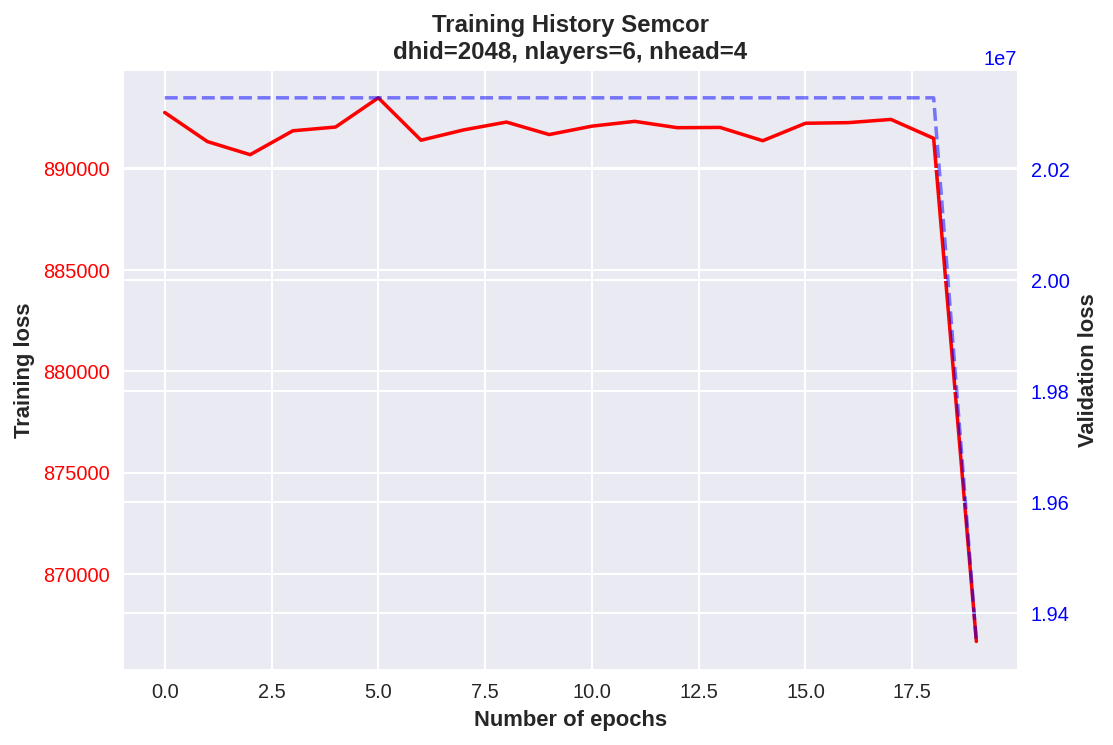

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 576x396 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid=2048, nlayers=6, nhead=4", fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, 'semcor_train_history_4heads_6layers_20epochs.eps'), format='eps')

#plt.download(resources_path + pwngc_path + '/pwngc_train_history_4heads_6layers_20epochs.png')

In [ ]:
train_history

Text(0, 0.5, 'validation_loss')

<Figure size 576x396 with 0 Axes>

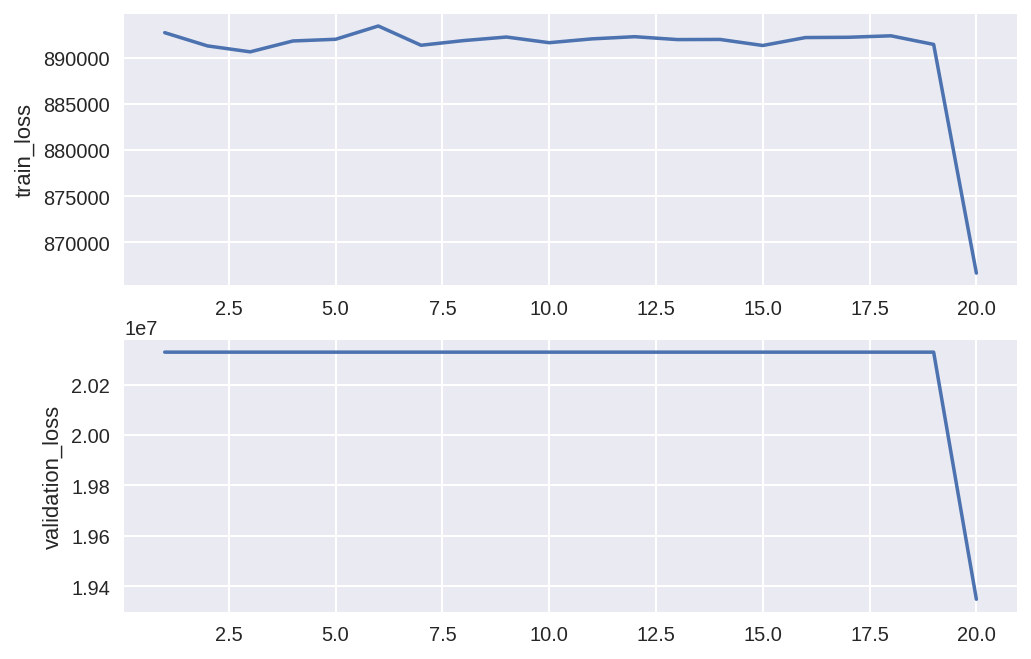

In [ ]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [ ]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_seneval2.pt'

In [ ]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [ ]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 


Number of words to be tested:  2282

[['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world'], [tensor([[2.5975e+04, 1.0159e+02, 1.8867e+05, 0.0000e+00, 1.3500e+01]]), tensor([[5.1311e+04, 1.0344e+02, 1.5946e+05, 0.0000e+00, 5.0000e-01]]), tensor([[6.8512e+04, 3.8500e+00, 8.1655e+04, 0.0000e+00, 5.0000e-01],
        [6.8512e+04, 3.8500e+00, 8.2204e+04, 0.0000e+00, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.4455e+05, 3.6870e+01, 5.0000e-01]]), tensor([[1.2556e+04, 1.7641e+02, 1.6253e+05, 1.8000e+02, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.6089e+05, 1.1358e+02, 5.0000e-01]]), tensor([[2.7169e+04, 1.0268e+02, 2.0028e+05, 0.0000e+00, 1.5000e+00],
        [2.7169e+04, 1.0268e+02, 1.8658e+05, 0.0000e+00, 1.5000e+00]]), tensor([[4.1253e+04, 3.0000e+00, 1.0926e+05, 0.0000e+00, 5.0000e-01]]), tensor([[1.1470e+05, 1.1838e+02, 1.0589e+05, 3.6870e+01, 1.5000e+00]]), tensor([[1.3542e+04, 8.7020e+01, 2.0535e+05, 2.5840e+

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: ignored

In [ ]:
save_predictions = torch.save(test_predictions, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=test_full_sent, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

## Tagging/Annotating

In [ ]:
tokens, predicted_indices, distances = T.tag(sentence="The boy is running towards the tree.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  ['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world']
Lemmatized Sentence:  ['art', 'change_ringing', 'peculiar', 'english', 'english', 'peculiarity', 'unintelligible', 'rest', 'world']
art
Vicinity Matrix-indices: {'B': tensor([124156, 166023,  60788], device='cuda:0'), 'C': tensor([124156, 166023,  60788], device='cuda:0'), 'D': tensor([124156, 166023,  60788], device='cuda:0'), 'E': tensor([124156, 166023,  60788], device='cuda:0')}
Vicinity Matrix-synsets: {'B': tensor([459914.2812, 460243.0312, 460927.7812], device='cuda:0',
       grad_fn=<TopkBackward0>), 'C': tensor([587049.3125, 587378.0625, 588061.8125], device='cuda:0',
       grad_fn=<TopkBackward0>), 'D': tensor([459915.2812, 460244.0312, 460930.7812], device='cuda:0',
       grad_fn=<TopkBackward0>), 'E': tensor([459914.2812, 460243.0312, 460927.7812], device='cuda:0',
       grad_fn=<TopkBackward0>)}
token    | kind | top_k | dist

art     , 

# Begin Training 3

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_3600hid'

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=20, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=3600, nlayers=9, nhead=4, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...
Validation ...
Epoch 20: train loss = 156183.7555, time = 679.4221 (s)


## plots

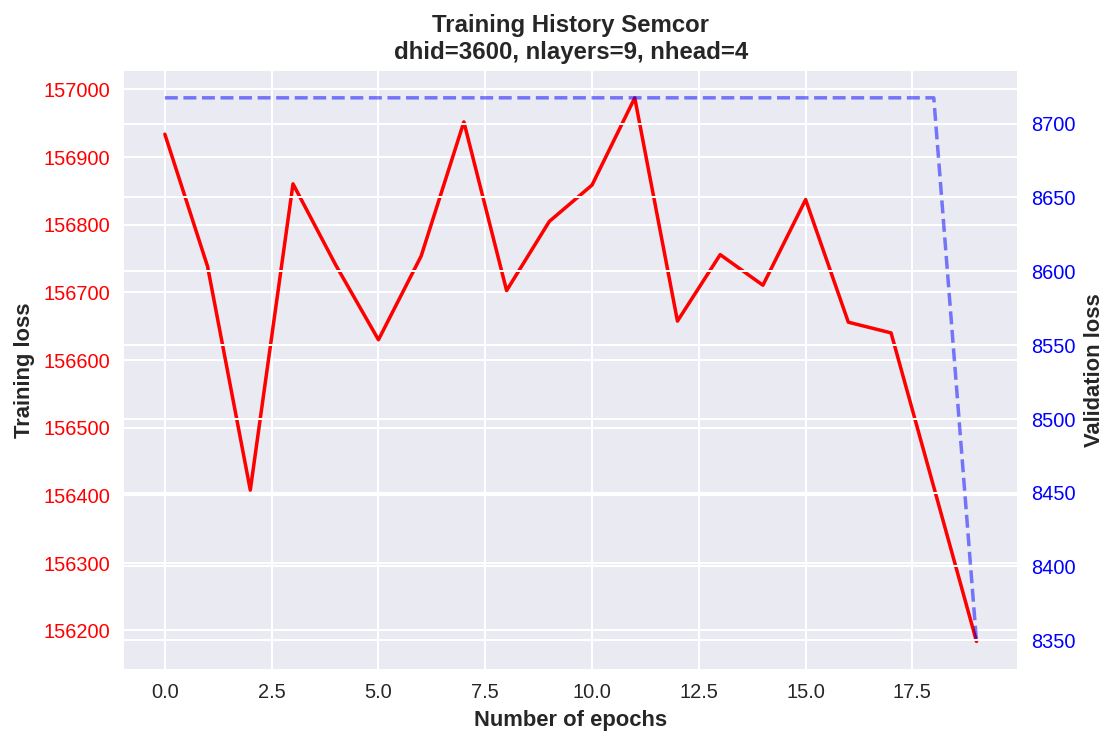

<Figure size 576x396 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid=3600, nlayers=9, nhead=4", fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, 'semcor_train_history_4heads_9layers_20epochs_3600hid_01dropout_.svg'), format='svg')

#plt.download(resources_path + pwngc_path + '/pwngc_train_history_4heads_6layers_20epochs.png')

In [ ]:
train_history

Text(0, 0.5, 'validation_loss')

<Figure size 576x396 with 0 Axes>

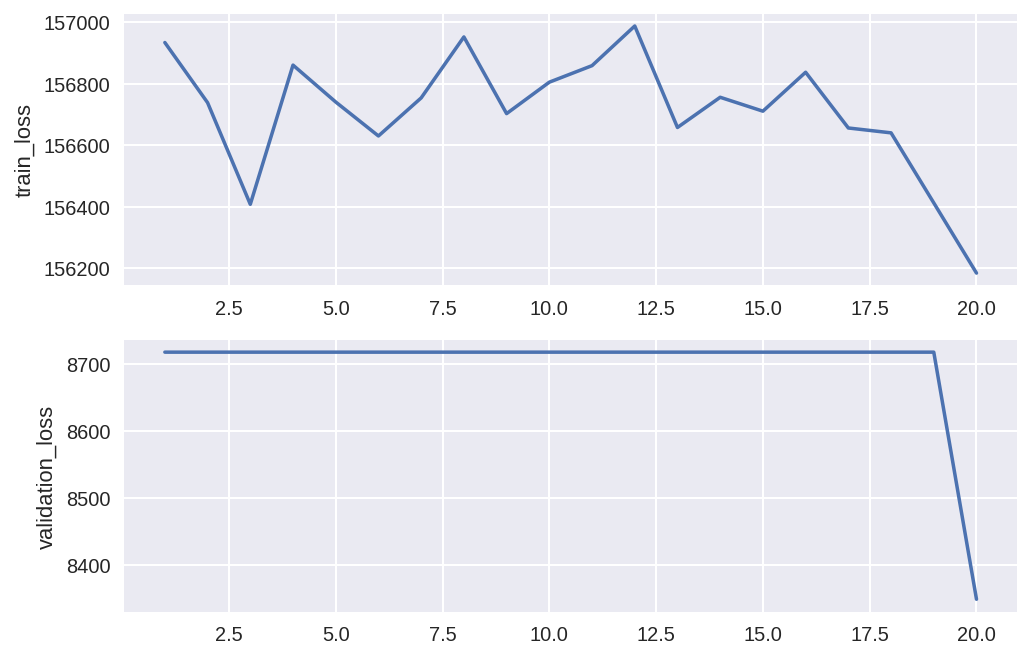

In [ ]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [ ]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_senseval2.pt'

In [ ]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [ ]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 

NameError: ignored

In [ ]:
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_3600hid'


In [ ]:
if not os.path.exists(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name)):
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME))#, test_dataset_name))
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name))

save_predictions = torch.save(test_history, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

NameError: ignored

In [ ]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=full_sentences, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20epochs_4heads_9layers_3600hid/senseval2/47_0.txt
Resume Results ...
Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20epochs_4heads_9layers_3600hid/senseval2/47_1.txt
Resume Results ...
Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20epochs_4heads_9layers_3600hid/senseval2/47_2.txt
Resume Results ...
Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20epochs_4heads_9layers_3600hid/senseval2/47_3.txt
Resume Results ...
Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20epochs_4heads_9layers_3600hid/senseval2/47_4.txt
Resume Results ...
Existing file in:  /content/drive/MyDrive/ColabNotebooks/wsd_resources/results/semcor/semcor_training_state_20

KeyboardInterrupt: ignored

## Tagging/Annotating

In [ ]:
if not os.path.exists(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME)):#, sentence_name)):
    os.mkdir(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME))#, sentence_name))

In [ ]:

tokens, predicted_indices, distances = T.tag(sentence="The CEO of apple is eating an apple.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  The CEO of apple is eating an apple.
Lemmatized Sentence:  ['ceo', 'apple', 'eat', 'apple']
ceo


# Begin Training 4

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_2000hid'

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=20, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=2000, nlayers=9, nhead=4, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...
Validation ...
Epoch 1: train loss = 144111.0212, time = 675.3984 (s)
Training ...
Validation ...
Epoch 2: train loss = 144134.8046, time = 682.3408 (s)
Training ...
Validation ...
Epoch 3: train loss = 144110.9178, time = 664.9777 (s)
Training ...
Validation ...
Epoch 4: train loss = 144123.2889, time = 668.2984 (s)
Training ...
Validation ...
Epoch 5: train loss = 144117.8578, time = 684.7356 (s)
Training ...
Validation ...
Epoch 6: train loss = 144089.6562, time = 690.4942 (s)
Training ...
Validation ...
Epoch 7: train loss = 144112.8168, time = 676.2955 (s)
Training ...
Validation ...
Epoch 8: train loss = 144109.7688, time = 670.3069 (s)
Training ...
Validation ...
Epoch 9: train loss = 144098.2289, time = 666.2821 (s)
Training ...
Validation ...
Epoch 10: train loss = 144103.7005, time = 661.3226 (s)
Training ...
Validation ...
Epoch 11: train loss = 144093.2049, time = 670.4141 (s)
Training ...
Validation ...
Epoch 12: train loss = 144088.3810, time = 662.5024 (s)
T

## plots

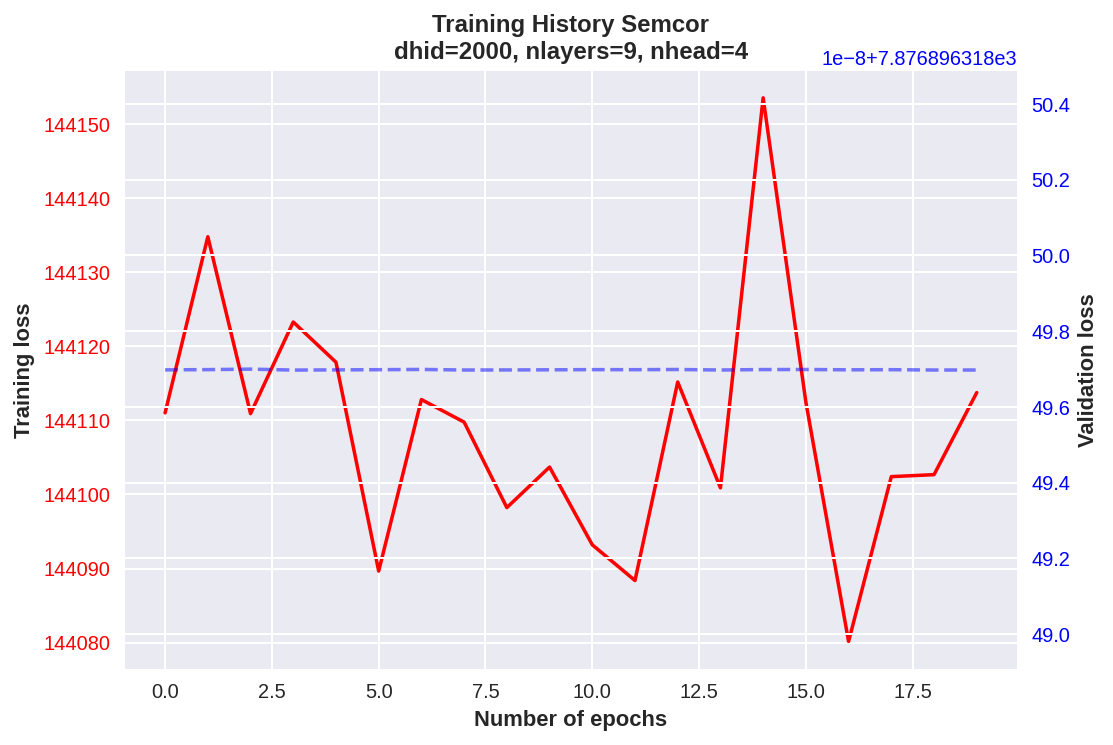

<Figure size 576x396 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid=2000, nlayers=9, nhead=4", fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, 'semcor_train_history_4heads_9layers_20epochs_2000hid_01dropout.svg'), format='svg')

#plt.download(resources_path + pwngc_path + '/pwngc_train_history_4heads_6layers_20epochs.png')

In [ ]:
train_history

defaultdict(list,
            {'train_loss': [144111.021230075,
              144134.8045721933,
              144110.91775708084,
              144123.2889427914,
              144117.8577705405,
              144089.65615093458,
              144112.81682631164,
              144109.76881056043,
              144098.22893110468,
              144103.70047768584,
              144093.20492622463,
              144088.38104024006,
              144115.18617154617,
              144100.89714431035,
              144153.5612804713,
              144112.46837874336,
              144080.15771901867,
              144102.4083428711,
              144102.67748096262,
              144113.75549248996],
             'validation_loss': [7876.896318496977,
              7876.8963184969825,
              7876.896318496996,
              7876.896318496971,
              7876.896318496977,
              7876.896318496981,
              7876.896318496988,
              7876.8963184969725,
         

Text(0, 0.5, 'validation_loss')

<Figure size 576x396 with 0 Axes>

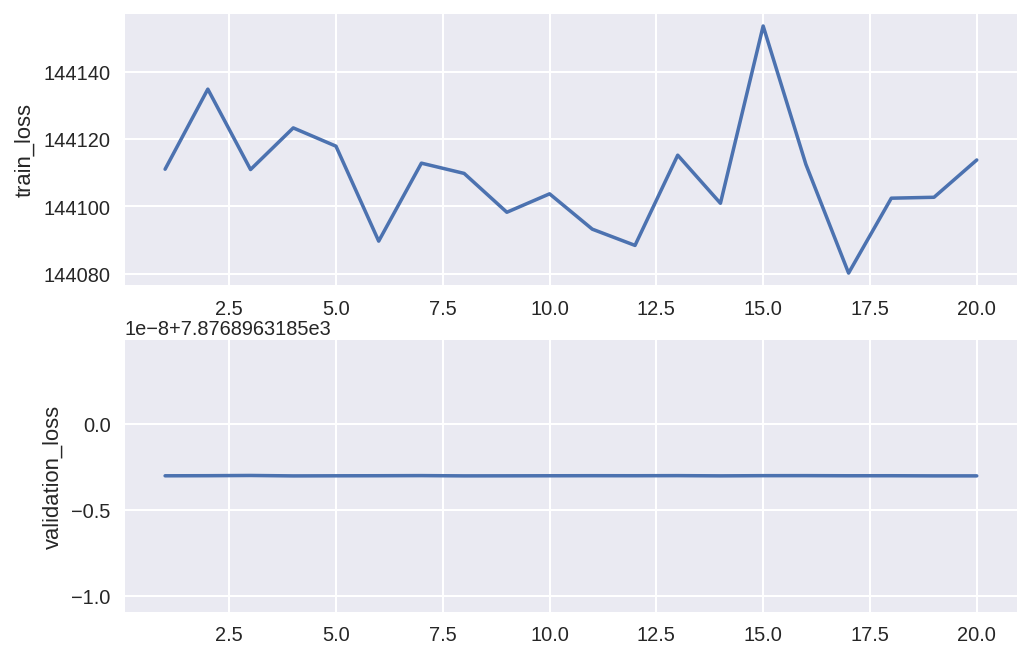

In [ ]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [ ]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_senseval2.pt'

In [ ]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [ ]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 


Number of words to be tested:  2282

[['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world'], [tensor([[2.5975e+04, 1.0159e+02, 1.8867e+05, 0.0000e+00, 1.3500e+01]]), tensor([[5.1311e+04, 1.0344e+02, 1.5946e+05, 0.0000e+00, 5.0000e-01]]), tensor([[6.8512e+04, 3.8500e+00, 8.1655e+04, 0.0000e+00, 5.0000e-01],
        [6.8512e+04, 3.8500e+00, 8.2204e+04, 0.0000e+00, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.4455e+05, 3.6870e+01, 5.0000e-01]]), tensor([[1.2556e+04, 1.7641e+02, 1.6253e+05, 1.8000e+02, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.6089e+05, 1.1358e+02, 5.0000e-01]]), tensor([[2.7169e+04, 1.0268e+02, 2.0028e+05, 0.0000e+00, 1.5000e+00],
        [2.7169e+04, 1.0268e+02, 1.8658e+05, 0.0000e+00, 1.5000e+00]]), tensor([[4.1253e+04, 3.0000e+00, 1.0926e+05, 0.0000e+00, 5.0000e-01]]), tensor([[1.1470e+05, 1.1838e+02, 1.0589e+05, 3.6870e+01, 1.5000e+00]]), tensor([[1.3542e+04, 8.7020e+01, 2.0535e+05, 2.5840e+

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:440: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


testing_loss =  <class 'float'> 4092005.5907993824
[tensor([76691]), tensor([39946]), tensor([61359]), tensor([75357])]
Input Sentence
['extraordinarily', 'satisfying', 'say', 'now']
Local_idx [tensor(76691), tensor(39946), tensor(61359), tensor(75357)]
extract labels [[1.3303100e+05 1.7881000e+02 1.7001150e+04 0.0000000e+00 5.0000000e-01]
 [3.4450000e+04 3.0750000e+01 1.2357068e+05 4.5570000e+01 5.0000000e-01]
 [1.3276100e+05 9.7680000e+01 6.6273980e+04 1.8000000e+02 5.0000000e-01]
 [7.3536000e+04 1.7092000e+02 7.8768220e+04 2.5840000e+01 5.0000000e-01]]
Labels:
[['inordinately.r.01'], ['hearty.s.02'], ['say.v.08'], ['now.r.04']]
testing_loss =  <class 'float'> 7289769.473918344
[tensor([76050]), tensor([107900]), tensor([72374]), tensor([205707]), tensor([45102]), tensor([93964]), tensor([30401]), tensor([201498]), tensor([26094]), tensor([3699])]
Input Sentence
['conversely', 'majority', 'unsuccessful', 'school', 'know', 'effort', 'educational', 'reform', 'doom', 'beforehand']
Local

In [ ]:
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_2000hid'


In [ ]:
if not os.path.exists(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name)):
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME))#, test_dataset_name))
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name))

save_predictions = torch.save(test_history, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=full_sentences, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

## Tagging/Annotating

In [ ]:
if not os.path.exists(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME)):#, sentence_name)):
    os.mkdir(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME))#, sentence_name))

In [ ]:

tokens, predicted_indices, distances = T.tag(sentence="The CEO of apple is eating an apple.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  The CEO of apple is eating an apple.
Lemmatized Sentence:  ['ceo', 'apple', 'eat', 'apple']
ceo


# Begin Training 5

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
max_epochs=20
dhid=3600
nhead=1
nlayers = 9
CHECKPOINT_NAME='semcor_training_state_20epochs_1head_9layers_3600hid'

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=max_epochs, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=dhid, nlayers=nlayers, nhead=nhead, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...
Validation ...
Epoch 1: train loss = 146830.3810, time = 722.8258 (s)
Training ...
Validation ...
Epoch 2: train loss = 146889.2871, time = 719.2205 (s)
Training ...
Validation ...
Epoch 3: train loss = 146767.7980, time = 714.4501 (s)
Training ...
Validation ...
Epoch 4: train loss = 146888.2390, time = 710.3079 (s)
Training ...
Validation ...
Epoch 5: train loss = 146876.2291, time = 715.3038 (s)
Training ...
Validation ...
Epoch 6: train loss = 146900.3984, time = 710.4002 (s)
Training ...
Validation ...
Epoch 7: train loss = 146836.6053, time = 707.9427 (s)
Training ...
Validation ...
Epoch 8: train loss = 146869.6028, time = 706.5260 (s)
Training ...
Validation ...
Epoch 9: train loss = 146836.7884, time = 708.3145 (s)
Training ...
Validation ...
Epoch 10: train loss = 146804.1418, time = 711.3262 (s)
Training ...
Validation ...
Epoch 11: train loss = 146872.2362, time = 713.6223 (s)
Training ...
Validation ...
Epoch 12: train loss = 146824.3741, time = 712.1011 (s)
T

## plots

In [ ]:
nlayers = 9

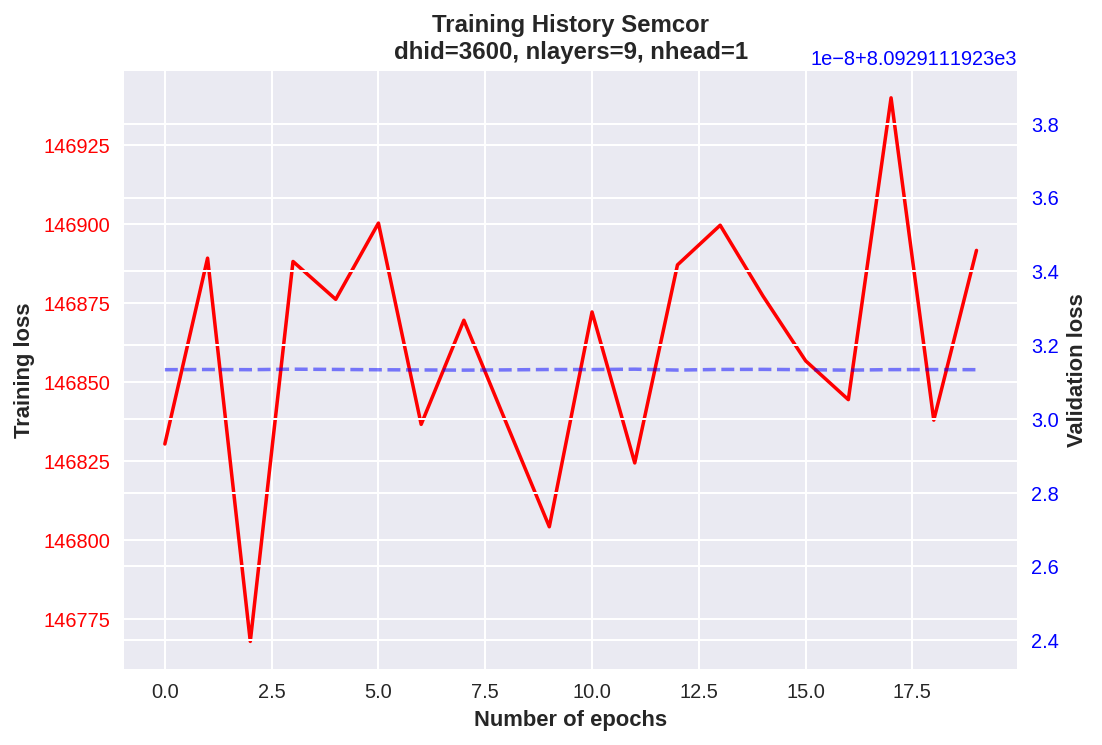

<Figure size 576x396 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid={}, nlayers={}, nhead={}".format(dhid, nlayers, nhead), fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, CHECKPOINT_NAME + '.svg'), format='svg') 
# 'semcor_train_history_4heads_9layers_20epochs_2000hid_01dropout.svg'), format='svg')



In [ ]:
train_history

In [ ]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [ ]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_senseval2.pt'

In [ ]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [ ]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 


Number of words to be tested:  2282

[['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world'], [tensor([[2.5975e+04, 1.0159e+02, 1.8867e+05, 0.0000e+00, 1.3500e+01]]), tensor([[5.1311e+04, 1.0344e+02, 1.5946e+05, 0.0000e+00, 5.0000e-01]]), tensor([[6.8512e+04, 3.8500e+00, 8.1655e+04, 0.0000e+00, 5.0000e-01],
        [6.8512e+04, 3.8500e+00, 8.2204e+04, 0.0000e+00, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.4455e+05, 3.6870e+01, 5.0000e-01]]), tensor([[1.2556e+04, 1.7641e+02, 1.6253e+05, 1.8000e+02, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.6089e+05, 1.1358e+02, 5.0000e-01]]), tensor([[2.7169e+04, 1.0268e+02, 2.0028e+05, 0.0000e+00, 1.5000e+00],
        [2.7169e+04, 1.0268e+02, 1.8658e+05, 0.0000e+00, 1.5000e+00]]), tensor([[4.1253e+04, 3.0000e+00, 1.0926e+05, 0.0000e+00, 5.0000e-01]]), tensor([[1.1470e+05, 1.1838e+02, 1.0589e+05, 3.6870e+01, 1.5000e+00]]), tensor([[1.3542e+04, 8.7020e+01, 2.0535e+05, 2.5840e+

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:440: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


testing_loss =  <class 'float'> 4092005.5907993824
[tensor([76691]), tensor([39946]), tensor([61359]), tensor([75357])]
Input Sentence
['extraordinarily', 'satisfying', 'say', 'now']
Local_idx [tensor(76691), tensor(39946), tensor(61359), tensor(75357)]
extract labels [[1.3303100e+05 1.7881000e+02 1.7001150e+04 0.0000000e+00 5.0000000e-01]
 [3.4450000e+04 3.0750000e+01 1.2357068e+05 4.5570000e+01 5.0000000e-01]
 [1.3276100e+05 9.7680000e+01 6.6273980e+04 1.8000000e+02 5.0000000e-01]
 [7.3536000e+04 1.7092000e+02 7.8768220e+04 2.5840000e+01 5.0000000e-01]]
Labels:
[['inordinately.r.01'], ['hearty.s.02'], ['say.v.08'], ['now.r.04']]
testing_loss =  <class 'float'> 7289769.473918344
[tensor([76050]), tensor([107900]), tensor([72374]), tensor([205707]), tensor([45102]), tensor([93964]), tensor([30401]), tensor([201498]), tensor([26094]), tensor([3699])]
Input Sentence
['conversely', 'majority', 'unsuccessful', 'school', 'know', 'effort', 'educational', 'reform', 'doom', 'beforehand']
Local

In [ ]:
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_2000hid'


In [ ]:
if not os.path.exists(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name)):
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME))#, test_dataset_name))
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name))

save_predictions = torch.save(test_history, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=full_sentences, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

## Tagging/Annotating

In [ ]:
if not os.path.exists(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME)):#, sentence_name)):
    os.mkdir(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME))#, sentence_name))

In [ ]:
tokens, predicted_indices, distances = T.tag(sentence="The CEO of apple is eating an apple.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  The CEO of apple is eating an apple.
Lemmatized Sentence:  ['ceo', 'apple', 'eat', 'apple']
ceo


# Begin Training 6 (MSELoss)

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
max_epochs=20
dhid=3600
nhead=1
nlayers = 9
CHECKPOINT_NAME='semcor_training_MSELOSS_state_20epochs_1head_9layers_3600hid'

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=max_epochs, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=dhid, nlayers=nlayers, nhead=nhead, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...


RuntimeError: ignored

## plots

In [ ]:
nlayers = 9

In [ ]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid={}, nlayers={}, nhead={}".format(dhid, nlayers, nhead), fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, CHECKPOINT_NAME + '.svg'), format='svg') 
# 'semcor_train_history_4heads_9layers_20epochs_2000hid_01dropout.svg'), format='svg')



In [ ]:
train_history

In [ ]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [ ]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_senseval2.pt'

In [ ]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [ ]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 


Number of words to be tested:  2282

[['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world'], [tensor([[2.5975e+04, 1.0159e+02, 1.8867e+05, 0.0000e+00, 1.3500e+01]]), tensor([[5.1311e+04, 1.0344e+02, 1.5946e+05, 0.0000e+00, 5.0000e-01]]), tensor([[6.8512e+04, 3.8500e+00, 8.1655e+04, 0.0000e+00, 5.0000e-01],
        [6.8512e+04, 3.8500e+00, 8.2204e+04, 0.0000e+00, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.4455e+05, 3.6870e+01, 5.0000e-01]]), tensor([[1.2556e+04, 1.7641e+02, 1.6253e+05, 1.8000e+02, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.6089e+05, 1.1358e+02, 5.0000e-01]]), tensor([[2.7169e+04, 1.0268e+02, 2.0028e+05, 0.0000e+00, 1.5000e+00],
        [2.7169e+04, 1.0268e+02, 1.8658e+05, 0.0000e+00, 1.5000e+00]]), tensor([[4.1253e+04, 3.0000e+00, 1.0926e+05, 0.0000e+00, 5.0000e-01]]), tensor([[1.1470e+05, 1.1838e+02, 1.0589e+05, 3.6870e+01, 1.5000e+00]]), tensor([[1.3542e+04, 8.7020e+01, 2.0535e+05, 2.5840e+

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:440: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


testing_loss =  <class 'float'> 4092005.5907993824
[tensor([76691]), tensor([39946]), tensor([61359]), tensor([75357])]
Input Sentence
['extraordinarily', 'satisfying', 'say', 'now']
Local_idx [tensor(76691), tensor(39946), tensor(61359), tensor(75357)]
extract labels [[1.3303100e+05 1.7881000e+02 1.7001150e+04 0.0000000e+00 5.0000000e-01]
 [3.4450000e+04 3.0750000e+01 1.2357068e+05 4.5570000e+01 5.0000000e-01]
 [1.3276100e+05 9.7680000e+01 6.6273980e+04 1.8000000e+02 5.0000000e-01]
 [7.3536000e+04 1.7092000e+02 7.8768220e+04 2.5840000e+01 5.0000000e-01]]
Labels:
[['inordinately.r.01'], ['hearty.s.02'], ['say.v.08'], ['now.r.04']]
testing_loss =  <class 'float'> 7289769.473918344
[tensor([76050]), tensor([107900]), tensor([72374]), tensor([205707]), tensor([45102]), tensor([93964]), tensor([30401]), tensor([201498]), tensor([26094]), tensor([3699])]
Input Sentence
['conversely', 'majority', 'unsuccessful', 'school', 'know', 'effort', 'educational', 'reform', 'doom', 'beforehand']
Local

In [ ]:
CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_2000hid'


In [ ]:
if not os.path.exists(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name)):
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME))#, test_dataset_name))
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name))

save_predictions = torch.save(test_history, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [ ]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=full_sentences, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

## Tagging/Annotating

In [ ]:
if not os.path.exists(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME)):#, sentence_name)):
    os.mkdir(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME))#, sentence_name))

In [ ]:
tokens, predicted_indices, distances = T.tag(sentence="The CEO of apple is eating an apple.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  The CEO of apple is eating an apple.
Lemmatized Sentence:  ['ceo', 'apple', 'eat', 'apple']
ceo


# Training 8 (changed normalized of Glove)

In [ ]:
m = torch.tensor([[1.,1.,1.], [3.,4.,5.], [14.,23.,34.]])
norms = torch.linalg.norm(m, dim=1)
print(norms)
inorms = 1/norms
print(inorms)
d = torch.mul(m.transpose(0,1), inorms).transpose(1,0)

print(d)
do = d + 1
print(do)
do2 = do / 2
print(do2)

tensor([ 1.7321,  7.0711, 43.3705])
tensor([0.5774, 0.1414, 0.0231])
tensor([[0.5774, 0.5774, 0.5774],
        [0.4243, 0.5657, 0.7071],
        [0.3228, 0.5303, 0.7839]])
tensor([[1.5774, 1.5774, 1.5774],
        [1.4243, 1.5657, 1.7071],
        [1.3228, 1.5303, 1.7839]])
tensor([[0.7887, 0.7887, 0.7887],
        [0.7121, 0.7828, 0.8536],
        [0.6614, 0.7652, 0.8920]])


In [ ]:
t = torch.tensor([1.,1.,1.])
torch.linalg.norm(t, dim=0)

tensor(1.7321)

In [259]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
#torch.backends.cudnn.benchmark = True
max_epochs=20
dhid=2000
nhead=4
nlayers = 9
CHECKPOINT_NAME='semcor_training_glove_norm_MSE_state_{}epochs_{}head_{}layers_{}hid'.format(max_epochs, nhead, nlayers, dhid)

T = RegTagger(use_cuda=use_cuda, device=device)

train_history = T.train(batch_size=64, 
                        num_workers=0, 
                        max_epochs=max_epochs, 
                        splittings=splittings, 
                        path2data=idx_file, 
                        data=list(datasetID.values()), 
                        embed_size=300, 
                        target_vocab=target_VOCAB, 
                        spatial_tags=SPATIAL_TAGS,
                        chkpt_path=CHECKPOINT_PATH, 
                        chkpt_name= CHECKPOINT_NAME+'.pt',
                        optimizer="adam",
                        d_model=300, d_hid=dhid, nlayers=nlayers, nhead=nhead, dropout=0.1,
                        lr=1e-3, gamma=0.95, 
                        shuffle=True
                        )

True
cuda
[['fulton_county_grand_jury', 'said', 'friday', 'investigation', 'atlanta', 'recent', 'primary_election', 'produced', 'evidence', 'irregularities', 'took_place'], [tensor([2.4963e+04, 1.1146e+02, 1.9427e+05, 0.0000e+00, 8.4465e+03],
       dtype=torch.float64), tensor([7.9038e+04, 7.6820e+01, 1.3067e+04, 1.3443e+02, 1.6850e+02],
       dtype=torch.float64), tensor([1.3228e+04, 1.0796e+02, 2.0227e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.4680e+05, 1.0392e+02, 6.5732e+04, 0.0000e+00, 1.5000e+00],
       dtype=torch.float64), tensor([7.2170e+04, 9.2940e+01, 1.3551e+05, 0.0000e+00, 5.0000e-01],
       dtype=torch.float64), tensor([1.5894e+04, 4.5440e+01, 1.3924e+05, 5.3130e+01, 5.0000e-01],
       dtype=torch.float64), tensor([6.3520e+04, 1.0171e+02, 1.4584e+05, 0.0000e+00, 3.5000e+00],
       dtype=torch.float64), tensor([9.6938e+04, 8.8980e+01, 2.7468e+04, 1.8000e+02, 1.5000e+00],
       dtype=torch.float64), tensor([8.8451e+04, 1.2394e+02, 1.3186e+05

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training ...
Validation ...
Epoch 1: train loss = 13122620273.0025, time = 1153.4646 (s)
Training ...
Validation ...
Epoch 2: train loss = 1616352937.0107, time = 1151.4462 (s)
Training ...
Validation ...
Epoch 3: train loss = 1538608821.7386, time = 1149.4619 (s)
Training ...
Validation ...
Epoch 4: train loss = 1503871977.8238, time = 1155.9343 (s)
Training ...
Validation ...
Epoch 5: train loss = 1511437418.6512, time = 1157.1784 (s)
Training ...
Validation ...
Epoch 6: train loss = 1476151183.6564, time = 1141.5356 (s)
Training ...
Validation ...
Epoch 7: train loss = 1577643029.8938, time = 1156.0214 (s)
Training ...
Validation ...
Epoch 8: train loss = 1549813868.0502, time = 1146.4817 (s)
Training ...
Validation ...
Epoch 9: train loss = 1494059559.5457, time = 1147.9365 (s)
Training ...
Validation ...
Epoch 10: train loss = 1510319289.7577, time = 1146.7221 (s)
Training ...
Validation ...
Epoch 11: train loss = 1556442784.8349, time = 1142.0242 (s)
Training ...
Validation ...
E

## plots

In [ ]:
nlayers = 9

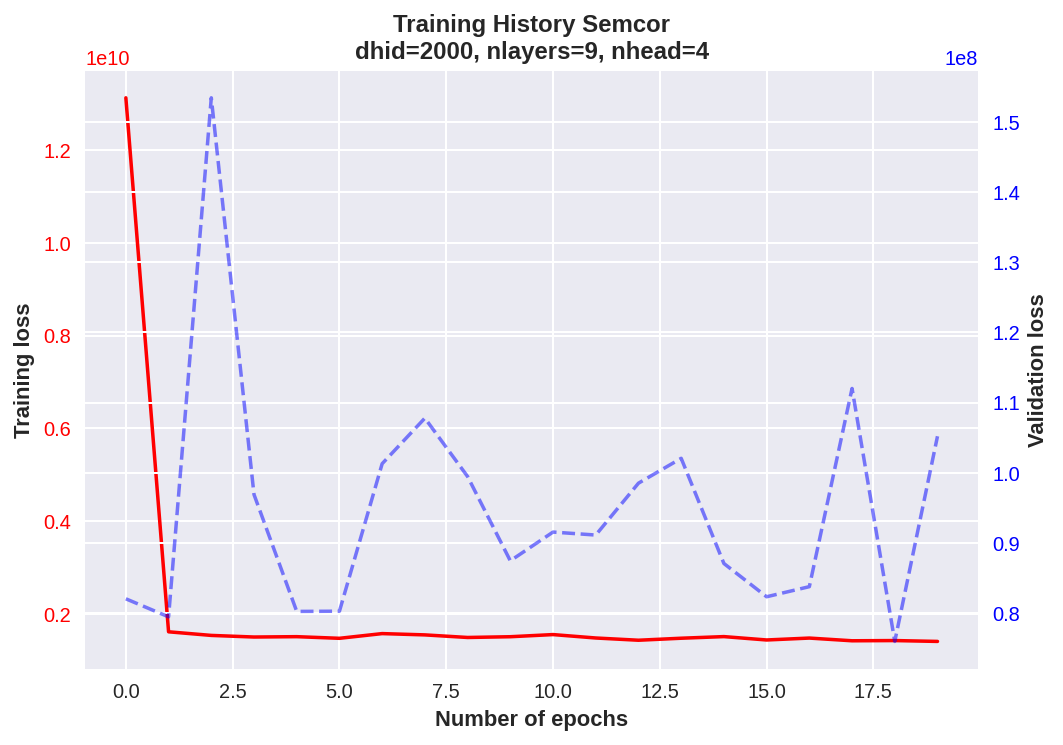

<Figure size 576x396 with 0 Axes>

In [260]:
fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(train_history["train_loss"], color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Training loss", fontweight='bold')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(train_history["validation_loss"], color='blue', linestyle='dashed', alpha=0.5)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Validation loss", fontweight='bold')

ax.set_xlabel("Number of epochs", fontweight='bold')
ax.set_title("Training History Semcor\ndhid={}, nlayers={}, nhead={}".format(dhid, nlayers, nhead), fontweight='bold')

fig1 = plt.gcf()
plt.show()
plt.draw()



fig1.savefig(os.path.join(resources_path, semcor_path, CHECKPOINT_NAME + '.svg'), format='svg') 
# 'semcor_train_history_4heads_9layers_20epochs_2000hid_01dropout.svg'), format='svg')



In [ ]:
train_history

Text(0, 0.5, 'validation_loss')

<Figure size 576x396 with 0 Axes>

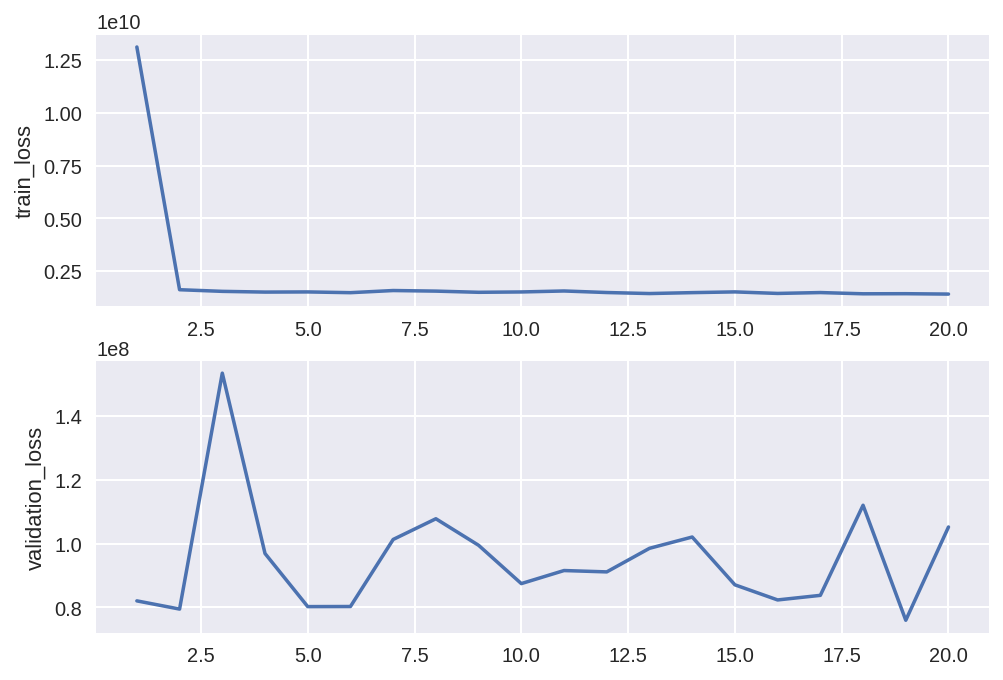

In [261]:
plt.figure()
f, axes = plt.subplots(2, 1)
x = range(1, 20+1)
axes[0].plot(x, train_history["train_loss"])
axes[0].set_ylabel('train_loss')

axes[1].plot(x, train_history["validation_loss"])
axes[1].set_ylabel('validation_loss')

In [ ]:
norm_train_loss = train_history["train_loss"] / np.sum(train_history["train_loss"])
norm_valid_loss = train_history["validation_loss"] / np.sum(train_history["validation_loss"])

Training interpretation:
- the training loss is no more oscillating 
- the validation loss is almost stable and fluctuates in epoch 19
- training loss and validation loss decrease together
- validation loss is greater than training loss, which indicates overfitting. But in my case, it may be because of loss calculation is different.
- validation loss is greater by one order of magnitude. This is caused by the fact that I calculate the geometric loss in a different way. In the training, I am strict because I want to include the radius in the learning process, however, in the testing, I only test whether the center is contained.
- why is this happening?
  1. different calculations of loss may lead to this difference
  2. the model is overfitting --> I need to set Dropout higher than that.


## Testing

In [ ]:
# check if the path to testing set exists, then ...

In [262]:
test_dataset_name = 'senseval2'
test_dataset = 'senseval2.pt'
test_dataset_id = 'senseval2_ID.pt'
test_full_sent = 'sent_senseval2.pt'

In [263]:
if os.path.exists(os.path.join(TESTING_PATH, test_dataset_id)):
  print("Found testing dataset id at: {}".format(os.path.join(TESTING_PATH, test_dataset_id)))
  senseval2_id = torch.load(os.path.join(TESTING_PATH, test_dataset_id))
else:
  senseval2 = parse_testing_data(os.path.join(TESTING_PATH, test_dataset))
  senseval2_id = data_id(senseval2)
  torch.save(senseval2_id, os.path.join(TESTING_PATH, test_dataset_id))


Found testing dataset id at: /content/drive/MyDrive/ColabNotebooks/wsd_resources/testing_datasets/senseval2_ID.pt


In [264]:
test_history = T.test(testing_data=list(senseval2_id.values()), 
                      splittings=list(senseval2_id.keys()),
                      path= os.path.join(TESTING_PATH, test_dataset_id),  
                      embed_size=300, 
                      batch_size=242, 
                      num_workers=0, 
                      target_vocab=target_VOCAB, 
                      spatial_tags=SPATIAL_TAGS, 
                      k=5,
                      shuffle=True) 


Number of words to be tested:  2282

[['art', 'change_ringing', 'peculiar', 'english', 'most', 'english', 'peculiarity', 'unintelligible', 'rest', 'world'], [tensor([[2.5975e+04, 1.0159e+02, 1.8867e+05, 0.0000e+00, 1.3500e+01]]), tensor([[5.1311e+04, 1.0344e+02, 1.5946e+05, 0.0000e+00, 5.0000e-01]]), tensor([[6.8512e+04, 3.8500e+00, 8.1655e+04, 0.0000e+00, 5.0000e-01],
        [6.8512e+04, 3.8500e+00, 8.2204e+04, 0.0000e+00, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.4455e+05, 3.6870e+01, 5.0000e-01]]), tensor([[1.2556e+04, 1.7641e+02, 1.6253e+05, 1.8000e+02, 5.0000e-01]]), tensor([[8.2768e+04, 8.7570e+01, 1.6089e+05, 1.1358e+02, 5.0000e-01]]), tensor([[2.7169e+04, 1.0268e+02, 2.0028e+05, 0.0000e+00, 1.5000e+00],
        [2.7169e+04, 1.0268e+02, 1.8658e+05, 0.0000e+00, 1.5000e+00]]), tensor([[4.1253e+04, 3.0000e+00, 1.0926e+05, 0.0000e+00, 5.0000e-01]]), tensor([[1.1470e+05, 1.1838e+02, 1.0589e+05, 3.6870e+01, 1.5000e+00]]), tensor([[1.3542e+04, 8.7020e+01, 2.0535e+05, 2.5840e+

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


testing_loss =  <class 'float'> 6728654.10489255
[tensor([75047]), tensor([205812]), tensor([26407]), tensor([204135, 215779]), tensor([9351]), tensor([36771]), tensor([26037]), tensor([119193]), tensor([34731, 34730]), tensor([120484]), tensor([36112]), tensor([52943]), tensor([39887]), tensor([42638]), tensor([46572]), tensor([21671]), tensor([110932])]
Input Sentence
['already', 'scientist', 'develop', 'test', 'base', 'newly', 'identify', 'gene', 'first', 'time', 'predict', 'otherwise', 'healthy', 'individual', 'likely', 'get', 'cancer']
Local_idx [tensor(75047), tensor(205812), tensor(26407), tensor(204135), tensor(9351), tensor(36771), tensor(26037), tensor(119193), tensor(34731), tensor(120484), tensor(36112), tensor(52943), tensor(39887), tensor(42638), tensor(46572), tensor(21671), tensor(110932)]
extract labels [[7.9830000e+03 1.7874000e+02 1.4205321e+05 0.0000000e+00 5.0000000e-01]
 [5.2355000e+04 9.0670000e+01 1.5265899e+05 0.0000000e+00 6.6750000e+02]
 [1.2653000e+04 9.1770

In [ ]:
#CHECKPOINT_NAME='semcor_training_state_20epochs_4heads_9layers_2000hid'


In [265]:
if not os.path.exists(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name)):
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME))#, test_dataset_name))
    os.mkdir(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name))

save_predictions = torch.save(test_history, os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [266]:
preds = torch.load(os.path.join(RESULTS_PATH, traindata_name, CHECKPOINT_NAME, test_dataset_name, test_dataset))

In [267]:
full_sentences = torch.load(os.path.join(TESTING_PATH, test_full_sent))
# in case the computation stops, keep track of existing files
processed_instances = save_results(predictions=preds, results_path=RESULTS_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME, testset_name=test_dataset_name, 
                testset_id=senseval2_id, document=full_sentences, 
                target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3)

RuntimeError: ignored

## Tagging/Annotating

In [ ]:
if not os.path.exists(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME)):#, sentence_name)):
    os.mkdir(os.path.join(ANNOTATION_PATH, traindata_name, CHECKPOINT_NAME))#, sentence_name))

In [ ]:
tokens, predicted_indices, distances = T.tag(sentence="The CEO of apple is eating an apple.", embed_size=300,
                                             target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS, k=3,
                                             annotation_path=ANNOTATION_PATH, traindata_name=traindata_name, chkpt_name=CHECKPOINT_NAME)

Initial Input:  The CEO of apple is eating an apple.
Lemmatized Sentence:  ['ceo', 'apple', 'eat', 'apple']
ceo
